# Setup

In [ ]:
Original settings: https://colab.research.google.com/github/deforum/stable-diffusion/blob/main/Deforum_Stable_Diffusion.ipynb

In [ ]:
#@markdown **NVIDIA GPU**
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15109 MiB, 15109 MiB



In [ ]:
#@markdown **Model and Output Paths**
# ask for the link
print("Local Path Variables:\n")

models_path = "/content/models" #@param {type:"string"}
output_path = "/content/output" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
mount_google_drive = True #@param {type:"boolean"}
force_remount = False

if mount_google_drive:
    from google.colab import drive # type: ignore
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path,force_remount=force_remount)
        models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
        output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion/project_take6" #@param {type:"string"}
        models_path = models_path_gdrive
        output_path = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")

import os
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

Local Path Variables:

Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/StableDiffusion/project_take6


In [ ]:
#@markdown **Setup Environment**

setup_environment = True #@param {type:"boolean"}
print_subprocess = False #@param {type:"boolean"}

if setup_environment:
    import subprocess, time
    print("Setting up environment...")
    start_time = time.time()
    all_process = [
        ['pip', 'install', 'torch==1.12.1+cu113', 'torchvision==0.13.1+cu113', '--extra-index-url', 'https://download.pytorch.org/whl/cu113'],
        ['pip', 'install', 'omegaconf==2.2.3', 'einops==0.4.1', 'pytorch-lightning==1.7.4', 'torchmetrics==0.9.3', 'torchtext==0.13.1', 'transformers==4.21.2', 'kornia==0.6.7'],
        ['git', 'clone', 'https://github.com/deforum/stable-diffusion'],
        ['pip', 'install', '-e', 'git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers'],
        ['pip', 'install', '-e', 'git+https://github.com/openai/CLIP.git@main#egg=clip'],
        ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq'],
        ['git', 'clone', 'https://github.com/shariqfarooq123/AdaBins.git'],
        ['git', 'clone', 'https://github.com/isl-org/MiDaS.git'],
        ['git', 'clone', 'https://github.com/MSFTserver/pytorch3d-lite.git'],
    ]
    for process in all_process:
        running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
        if print_subprocess:
            print(running)
    
    print(subprocess.run(['git', 'clone', 'https://github.com/deforum/k-diffusion/'], stdout=subprocess.PIPE).stdout.decode('utf-8'))
    with open('k-diffusion/k_diffusion/__init__.py', 'w') as f:
        f.write('')

    end_time = time.time()
    print(f"Environment set up in {end_time-start_time:.0f} seconds")

Setting up environment...

Environment set up in 46 seconds


In [ ]:
#@markdown **Python Definitions**
import json
from IPython import display

import gc, math, os, pathlib, subprocess, sys, time
import cv2
import numpy as np
import pandas as pd
import random
import requests
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from omegaconf import OmegaConf
from PIL import Image
from pytorch_lightning import seed_everything
from skimage.exposure import match_histograms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from types import SimpleNamespace
from torch import autocast
import re
from scipy.ndimage import gaussian_filter

sys.path.extend([
    'src/taming-transformers',
    'src/clip',
    'stable-diffusion/',
    'k-diffusion',
    'pytorch3d-lite',
    'AdaBins',
    'MiDaS',
])

import py3d_tools as p3d

from helpers import DepthModel, sampler_fn
from k_diffusion.external import CompVisDenoiser
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

def sanitize(prompt):
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    tmp = ''.join(filter(whitelist.__contains__, prompt))
    return tmp.replace(' ', '_')

from functools import reduce
def construct_RotationMatrixHomogenous(rotation_angles):
    assert(type(rotation_angles)==list and len(rotation_angles)==3)
    RH = np.eye(4,4)
    cv2.Rodrigues(np.array(rotation_angles), RH[0:3, 0:3])
    return RH

# https://en.wikipedia.org/wiki/Rotation_matrix
def getRotationMatrixManual(rotation_angles):
	
    rotation_angles = [np.deg2rad(x) for x in rotation_angles]
    
    phi         = rotation_angles[0] # around x
    gamma       = rotation_angles[1] # around y
    theta       = rotation_angles[2] # around z
    
    # X rotation
    Rphi        = np.eye(4,4)
    sp          = np.sin(phi)
    cp          = np.cos(phi)
    Rphi[1,1]   = cp
    Rphi[2,2]   = Rphi[1,1]
    Rphi[1,2]   = -sp
    Rphi[2,1]   = sp
    
    # Y rotation
    Rgamma        = np.eye(4,4)
    sg            = np.sin(gamma)
    cg            = np.cos(gamma)
    Rgamma[0,0]   = cg
    Rgamma[2,2]   = Rgamma[0,0]
    Rgamma[0,2]   = sg
    Rgamma[2,0]   = -sg
    
    # Z rotation (in-image-plane)
    Rtheta      = np.eye(4,4)
    st          = np.sin(theta)
    ct          = np.cos(theta)
    Rtheta[0,0] = ct
    Rtheta[1,1] = Rtheta[0,0]
    Rtheta[0,1] = -st
    Rtheta[1,0] = st
    
    R           = reduce(lambda x,y : np.matmul(x,y), [Rphi, Rgamma, Rtheta]) 
    
    return R


def getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sidelength):
    
    ptsIn2D      =  ptsIn[0,:]
    ptsOut2D     =  ptsOut[0,:]
    ptsOut2Dlist =  []
    ptsIn2Dlist  =  []
    
    for i in range(0,4):
        ptsOut2Dlist.append([ptsOut2D[i,0], ptsOut2D[i,1]])
        ptsIn2Dlist.append([ptsIn2D[i,0], ptsIn2D[i,1]])
    
    pin  =  np.array(ptsIn2Dlist)   +  [W/2.,H/2.]
    pout = (np.array(ptsOut2Dlist)  +  [1.,1.]) * (0.5*sidelength)
    pin  = pin.astype(np.float32)
    pout = pout.astype(np.float32)
    
    return pin, pout

def warpMatrix(W, H, theta, phi, gamma, scale, fV):
    
    # M is to be estimated
    M          = np.eye(4, 4)
    
    fVhalf     = np.deg2rad(fV/2.)
    d          = np.sqrt(W*W+H*H)
    sideLength = scale*d/np.cos(fVhalf)
    h          = d/(2.0*np.sin(fVhalf))
    n          = h-(d/2.0);
    f          = h+(d/2.0);
    
    # Translation along Z-axis by -h
    T       = np.eye(4,4)
    T[2,3]  = -h
    
    # Rotation matrices around x,y,z
    R = getRotationMatrixManual([phi, gamma, theta])
    
    
    # Projection Matrix 
    P       = np.eye(4,4)
    P[0,0]  = 1.0/np.tan(fVhalf)
    P[1,1]  = P[0,0]
    P[2,2]  = -(f+n)/(f-n)
    P[2,3]  = -(2.0*f*n)/(f-n)
    P[3,2]  = -1.0
    
    # pythonic matrix multiplication
    F       = reduce(lambda x,y : np.matmul(x,y), [P, T, R]) 
    
    # shape should be 1,4,3 for ptsIn and ptsOut since perspectiveTransform() expects data in this way. 
    # In C++, this can be achieved by Mat ptsIn(1,4,CV_64FC3);
    ptsIn = np.array([[
                 [-W/2., H/2., 0.],[ W/2., H/2., 0.],[ W/2.,-H/2., 0.],[-W/2.,-H/2., 0.]
                 ]])
    ptsOut  = np.array(np.zeros((ptsIn.shape), dtype=ptsIn.dtype))
    ptsOut  = cv2.perspectiveTransform(ptsIn, F)
    
    ptsInPt2f, ptsOutPt2f = getPoints_for_PerspectiveTranformEstimation(ptsIn, ptsOut, W, H, sideLength)
    
    # check float32 otherwise OpenCV throws an error
    assert(ptsInPt2f.dtype  == np.float32)
    assert(ptsOutPt2f.dtype == np.float32)
    M33 = cv2.getPerspectiveTransform(ptsInPt2f,ptsOutPt2f)

    return M33, sideLength

def anim_frame_warp_2d(prev_img_cv2, args, anim_args, keys, frame_idx):
    angle = keys.angle_series[frame_idx]
    zoom = keys.zoom_series[frame_idx]
    translation_x = keys.translation_x_series[frame_idx]
    translation_y = keys.translation_y_series[frame_idx]

    center = (args.W // 2, args.H // 2)
    trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
    rot_mat = cv2.getRotationMatrix2D(center, angle, zoom)
    trans_mat = np.vstack([trans_mat, [0,0,1]])
    rot_mat = np.vstack([rot_mat, [0,0,1]])
    if anim_args.flip_2d_perspective:
        perspective_flip_theta = keys.perspective_flip_theta_series[frame_idx]
        perspective_flip_phi = keys.perspective_flip_phi_series[frame_idx]
        perspective_flip_gamma = keys.perspective_flip_gamma_series[frame_idx]
        perspective_flip_fv = keys.perspective_flip_fv_series[frame_idx]
        M,sl = warpMatrix(args.W, args.H, perspective_flip_theta, perspective_flip_phi, perspective_flip_gamma, 1., perspective_flip_fv);
        post_trans_mat = np.float32([[1, 0, (args.W-sl)/2], [0, 1, (args.H-sl)/2]])
        post_trans_mat = np.vstack([post_trans_mat, [0,0,1]])
        bM = np.matmul(M, post_trans_mat)
        xform = np.matmul(bM, rot_mat, trans_mat)
    else:
        xform = np.matmul(rot_mat, trans_mat)

    return cv2.warpPerspective(
        prev_img_cv2,
        xform,
        (prev_img_cv2.shape[1], prev_img_cv2.shape[0]),
        borderMode=cv2.BORDER_WRAP if anim_args.border == 'wrap' else cv2.BORDER_REPLICATE
    )

def anim_frame_warp_3d(prev_img_cv2, depth, anim_args, keys, frame_idx):
    TRANSLATION_SCALE = 1.0/200.0 # matches Disco
    translate_xyz = [
        -keys.translation_x_series[frame_idx] * TRANSLATION_SCALE, 
        keys.translation_y_series[frame_idx] * TRANSLATION_SCALE, 
        -keys.translation_z_series[frame_idx] * TRANSLATION_SCALE
    ]
    rotate_xyz = [
        math.radians(keys.rotation_3d_x_series[frame_idx]), 
        math.radians(keys.rotation_3d_y_series[frame_idx]), 
        math.radians(keys.rotation_3d_z_series[frame_idx])
    ]
    rot_mat = p3d.euler_angles_to_matrix(torch.tensor(rotate_xyz, device=device), "XYZ").unsqueeze(0)
    result = transform_image_3d(prev_img_cv2, depth, rot_mat, translate_xyz, anim_args)
    torch.cuda.empty_cache()
    return result

def add_noise(sample: torch.Tensor, noise_amt: float) -> torch.Tensor:
    return sample + torch.randn(sample.shape, device=sample.device) * noise_amt

def get_output_folder(output_path, batch_folder):
    out_path = os.path.join(output_path,time.strftime('%Y-%m'))
    if batch_folder != "":
        out_path = os.path.join(out_path, batch_folder)
    os.makedirs(out_path, exist_ok=True)
    return out_path

def load_img(path, shape, use_alpha_as_mask=False):
    # use_alpha_as_mask: Read the alpha channel of the image as the mask image
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw)
    else:
        image = Image.open(path)

    if use_alpha_as_mask:
        image = image.convert('RGBA')
    else:
        image = image.convert('RGB')

    image = image.resize(shape, resample=Image.LANCZOS)

    mask_image = None
    if use_alpha_as_mask:
      # Split alpha channel into a mask_image
      red, green, blue, alpha = Image.Image.split(image)
      mask_image = alpha.convert('L')
      image = image.convert('RGB')

    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    image = 2.*image - 1.

    return image, mask_image

def load_mask_latent(mask_input, shape):
    # mask_input (str or PIL Image.Image): Path to the mask image or a PIL Image object
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    
    if isinstance(mask_input, str): # mask input is probably a file name
        if mask_input.startswith('http://') or mask_input.startswith('https://'):
            mask_image = Image.open(requests.get(mask_input, stream=True).raw).convert('RGBA')
        else:
            mask_image = Image.open(mask_input).convert('RGBA')
    elif isinstance(mask_input, Image.Image):
        mask_image = mask_input
    else:
        raise Exception("mask_input must be a PIL image or a file name")

    mask_w_h = (shape[-1], shape[-2])
    mask = mask_image.resize(mask_w_h, resample=Image.LANCZOS)
    mask = mask.convert("L")
    return mask

def prepare_mask(mask_input, mask_shape, mask_brightness_adjust=1.0, mask_contrast_adjust=1.0):
    # mask_input (str or PIL Image.Image): Path to the mask image or a PIL Image object
    # shape (list-like len(4)): shape of the image to match, usually latent_image.shape
    # mask_brightness_adjust (non-negative float): amount to adjust brightness of the iamge, 
    #     0 is black, 1 is no adjustment, >1 is brighter
    # mask_contrast_adjust (non-negative float): amount to adjust contrast of the image, 
    #     0 is a flat grey image, 1 is no adjustment, >1 is more contrast
    
    mask = load_mask_latent(mask_input, mask_shape)

    # Mask brightness/contrast adjustments
    if mask_brightness_adjust != 1:
        mask = TF.adjust_brightness(mask, mask_brightness_adjust)
    if mask_contrast_adjust != 1:
        mask = TF.adjust_contrast(mask, mask_contrast_adjust)

    # Mask image to array
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask,(4,1,1))
    mask = np.expand_dims(mask,axis=0)
    mask = torch.from_numpy(mask)

    if args.invert_mask:
        mask = ( (mask - 0.5) * -1) + 0.5
    
    mask = np.clip(mask,0,1)
    return mask

def maintain_colors(prev_img, color_match_sample, mode):
    if mode == 'Match Frame 0 RGB':
        return match_histograms(prev_img, color_match_sample, multichannel=True)
    elif mode == 'Match Frame 0 HSV':
        prev_img_hsv = cv2.cvtColor(prev_img, cv2.COLOR_RGB2HSV)
        color_match_hsv = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2HSV)
        matched_hsv = match_histograms(prev_img_hsv, color_match_hsv, multichannel=True)
        return cv2.cvtColor(matched_hsv, cv2.COLOR_HSV2RGB)
    else: # Match Frame 0 LAB
        prev_img_lab = cv2.cvtColor(prev_img, cv2.COLOR_RGB2LAB)
        color_match_lab = cv2.cvtColor(color_match_sample, cv2.COLOR_RGB2LAB)
        matched_lab = match_histograms(prev_img_lab, color_match_lab, multichannel=True)
        return cv2.cvtColor(matched_lab, cv2.COLOR_LAB2RGB)


#
# Callback functions
#
class SamplerCallback(object):
    # Creates the callback function to be passed into the samplers for each step
    def __init__(self, args, mask=None, init_latent=None, sigmas=None, sampler=None,
                  verbose=False):
        self.sampler_name = args.sampler
        self.dynamic_threshold = args.dynamic_threshold
        self.static_threshold = args.static_threshold
        self.mask = mask
        self.init_latent = init_latent 
        self.sigmas = sigmas
        self.sampler = sampler
        self.verbose = verbose

        self.batch_size = args.n_samples
        self.save_sample_per_step = args.save_sample_per_step
        self.show_sample_per_step = args.show_sample_per_step
        self.paths_to_image_steps = [os.path.join( args.outdir, f"{args.timestring}_{index:02}_{args.seed}") for index in range(args.n_samples) ]

        if self.save_sample_per_step:
            for path in self.paths_to_image_steps:
                os.makedirs(path, exist_ok=True)

        self.step_index = 0

        self.noise = None
        if init_latent is not None:
            self.noise = torch.randn_like(init_latent, device=device)

        self.mask_schedule = None
        if sigmas is not None and len(sigmas) > 0:
            self.mask_schedule, _ = torch.sort(sigmas/torch.max(sigmas))
        elif len(sigmas) == 0:
            self.mask = None # no mask needed if no steps (usually happens because strength==1.0)

        if self.sampler_name in ["plms","ddim"]: 
            if mask is not None:
                assert sampler is not None, "Callback function for stable-diffusion samplers requires sampler variable"

        if self.sampler_name in ["plms","ddim"]: 
            # Callback function formated for compvis latent diffusion samplers
            self.callback = self.img_callback_
        else: 
            # Default callback function uses k-diffusion sampler variables
            self.callback = self.k_callback_

        self.verbose_print = print if verbose else lambda *args, **kwargs: None

    def view_sample_step(self, latents, path_name_modifier=''):
        if self.save_sample_per_step or self.show_sample_per_step:
            samples = model.decode_first_stage(latents)
            if self.save_sample_per_step:
                fname = f'{path_name_modifier}_{self.step_index:05}.png'
                for i, sample in enumerate(samples):
                    sample = sample.double().cpu().add(1).div(2).clamp(0, 1)
                    sample = torch.tensor(np.array(sample))
                    grid = make_grid(sample, 4).cpu()
                    TF.to_pil_image(grid).save(os.path.join(self.paths_to_image_steps[i], fname))
            if self.show_sample_per_step:
                print(path_name_modifier)
                self.display_images(samples)
        return

    def display_images(self, images):
        images = images.double().cpu().add(1).div(2).clamp(0, 1)
        images = torch.tensor(np.array(images))
        grid = make_grid(images, 4).cpu()
        display.display(TF.to_pil_image(grid))
        return

    # The callback function is applied to the image at each step
    def dynamic_thresholding_(self, img, threshold):
        # Dynamic thresholding from Imagen paper (May 2022)
        s = np.percentile(np.abs(img.cpu()), threshold, axis=tuple(range(1,img.ndim)))
        s = np.max(np.append(s,1.0))
        torch.clamp_(img, -1*s, s)
        torch.FloatTensor.div_(img, s)

    # Callback for samplers in the k-diffusion repo, called thus:
    #   callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigmas[i], 'denoised': denoised})
    def k_callback_(self, args_dict):
        self.step_index = args_dict['i']
        if self.dynamic_threshold is not None:
            self.dynamic_thresholding_(args_dict['x'], self.dynamic_threshold)
        if self.static_threshold is not None:
            torch.clamp_(args_dict['x'], -1*self.static_threshold, self.static_threshold)
        if self.mask is not None:
            init_noise = self.init_latent + self.noise * args_dict['sigma']
            is_masked = torch.logical_and(self.mask >= self.mask_schedule[args_dict['i']], self.mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + args_dict['x'] * torch.where(is_masked,0,1)
            args_dict['x'].copy_(new_img)

        self.view_sample_step(args_dict['denoised'], "x0_pred")

    # Callback for Compvis samplers
    # Function that is called on the image (img) and step (i) at each step
    def img_callback_(self, img, i):
        self.step_index = i
        # Thresholding functions
        if self.dynamic_threshold is not None:
            self.dynamic_thresholding_(img, self.dynamic_threshold)
        if self.static_threshold is not None:
            torch.clamp_(img, -1*self.static_threshold, self.static_threshold)
        if self.mask is not None:
            i_inv = len(self.sigmas) - i - 1
            init_noise = self.sampler.stochastic_encode(self.init_latent, torch.tensor([i_inv]*self.batch_size).to(device), noise=self.noise)
            is_masked = torch.logical_and(self.mask >= self.mask_schedule[i], self.mask != 0 )
            new_img = init_noise * torch.where(is_masked,1,0) + img * torch.where(is_masked,0,1)
            img.copy_(new_img)

        self.view_sample_step(img, "x")

def sample_from_cv2(sample: np.ndarray) -> torch.Tensor:
    sample = ((sample.astype(float) / 255.0) * 2) - 1
    sample = sample[None].transpose(0, 3, 1, 2).astype(np.float16)
    sample = torch.from_numpy(sample)
    return sample

def sample_to_cv2(sample: torch.Tensor, type=np.uint8) -> np.ndarray:
    sample_f32 = rearrange(sample.squeeze().cpu().numpy(), "c h w -> h w c").astype(np.float32)
    sample_f32 = ((sample_f32 * 0.5) + 0.5).clip(0, 1)
    sample_int8 = (sample_f32 * 255)
    return sample_int8.astype(type)

def transform_image_3d(prev_img_cv2, depth_tensor, rot_mat, translate, anim_args):
    # adapted and optimized version of transform_image_3d from Disco Diffusion https://github.com/alembics/disco-diffusion 
    w, h = prev_img_cv2.shape[1], prev_img_cv2.shape[0]

    aspect_ratio = float(w)/float(h)
    near, far, fov_deg = anim_args.near_plane, anim_args.far_plane, anim_args.fov
    persp_cam_old = p3d.FoVPerspectiveCameras(near, far, aspect_ratio, fov=fov_deg, degrees=True, device=device)
    persp_cam_new = p3d.FoVPerspectiveCameras(near, far, aspect_ratio, fov=fov_deg, degrees=True, R=rot_mat, T=torch.tensor([translate]), device=device)

    # range of [-1,1] is important to torch grid_sample's padding handling
    y,x = torch.meshgrid(torch.linspace(-1.,1.,h,dtype=torch.float32,device=device),torch.linspace(-1.,1.,w,dtype=torch.float32,device=device))
    z = torch.as_tensor(depth_tensor, dtype=torch.float32, device=device)
    xyz_old_world = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)

    xyz_old_cam_xy = persp_cam_old.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]
    xyz_new_cam_xy = persp_cam_new.get_full_projection_transform().transform_points(xyz_old_world)[:,0:2]

    offset_xy = xyz_new_cam_xy - xyz_old_cam_xy
    # affine_grid theta param expects a batch of 2D mats. Each is 2x3 to do rotation+translation.
    identity_2d_batch = torch.tensor([[1.,0.,0.],[0.,1.,0.]], device=device).unsqueeze(0)
    # coords_2d will have shape (N,H,W,2).. which is also what grid_sample needs.
    coords_2d = torch.nn.functional.affine_grid(identity_2d_batch, [1,1,h,w], align_corners=False)
    offset_coords_2d = coords_2d - torch.reshape(offset_xy, (h,w,2)).unsqueeze(0)

    image_tensor = rearrange(torch.from_numpy(prev_img_cv2.astype(np.float32)), 'h w c -> c h w').to(device)
    new_image = torch.nn.functional.grid_sample(
        image_tensor.add(1/512 - 0.0001).unsqueeze(0), 
        offset_coords_2d, 
        mode=anim_args.sampling_mode, 
        padding_mode=anim_args.padding_mode, 
        align_corners=False
    )

    # convert back to cv2 style numpy array
    result = rearrange(
        new_image.squeeze().clamp(0,255), 
        'c h w -> h w c'
    ).cpu().numpy().astype(prev_img_cv2.dtype)
    return result

def check_is_number(value):
    float_pattern = r'^(?=.)([+-]?([0-9]*)(\.([0-9]+))?)$'
    return re.match(float_pattern, value)

# prompt weighting with colons and number coefficients (like 'bacon:0.75 eggs:0.25')
# borrowed from https://github.com/kylewlacy/stable-diffusion/blob/0a4397094eb6e875f98f9d71193e350d859c4220/ldm/dream/conditioning.py
# and https://github.com/raefu/stable-diffusion-automatic/blob/unstablediffusion/modules/processing.py
def get_uc_and_c(prompts, model, args, frame = 0):
    prompt = prompts[0] # they are the same in a batch anyway

    # get weighted sub-prompts
    negative_subprompts, positive_subprompts = split_weighted_subprompts(
        prompt, frame, not args.normalize_prompt_weights
    )

    uc = get_learned_conditioning(model, negative_subprompts, "", args, -1)
    c = get_learned_conditioning(model, positive_subprompts, prompt, args, 1)

    return (uc, c)

def get_learned_conditioning(model, weighted_subprompts, text, args, sign = 1):
    if len(weighted_subprompts) < 1:
        log_tokenization(text, model, args.log_weighted_subprompts, sign)
        c = model.get_learned_conditioning(args.n_samples * [text])
    else:
        c = None
        for subtext, subweight in weighted_subprompts:
            log_tokenization(subtext, model, args.log_weighted_subprompts, sign * subweight)
            if c is None:
                c = model.get_learned_conditioning(args.n_samples * [subtext])
                c *= subweight
            else:
                c.add_(model.get_learned_conditioning(args.n_samples * [subtext]), alpha=subweight)
        
    return c

def parse_weight(match, frame = 0)->float:
    import numexpr
    w_raw = match.group("weight")
    if w_raw == None:
        return 1
    if check_is_number(w_raw):
        return float(w_raw)
    else:
        t = frame
        if len(w_raw) < 3:
            print('the value inside `-characters cannot represent a math function')
            return 1
        return float(numexpr.evaluate(w_raw[1:-1]))

def normalize_prompt_weights(parsed_prompts):
    if len(parsed_prompts) == 0:
        return parsed_prompts
    weight_sum = sum(map(lambda x: x[1], parsed_prompts))
    if weight_sum == 0:
        print(
            "Warning: Subprompt weights add up to zero. Discarding and using even weights instead.")
        equal_weight = 1 / max(len(parsed_prompts), 1)
        return [(x[0], equal_weight) for x in parsed_prompts]
    return [(x[0], x[1] / weight_sum) for x in parsed_prompts]

def split_weighted_subprompts(text, frame = 0, skip_normalize=False):
    """
    grabs all text up to the first occurrence of ':'
    uses the grabbed text as a sub-prompt, and takes the value following ':' as weight
    if ':' has no value defined, defaults to 1.0
    repeats until no text remaining
    """
    prompt_parser = re.compile("""
            (?P<prompt>         # capture group for 'prompt'
            (?:\\\:|[^:])+      # match one or more non ':' characters or escaped colons '\:'
            )                   # end 'prompt'
            (?:                 # non-capture group
            :+                  # match one or more ':' characters
            (?P<weight>((        # capture group for 'weight'
            -?\d+(?:\.\d+)?     # match positive or negative integer or decimal number
            )|(                 # or
            `[\S\s]*?`# a math function
            )))?                 # end weight capture group, make optional
            \s*                 # strip spaces after weight
            |                   # OR
            $                   # else, if no ':' then match end of line
            )                   # end non-capture group
            """, re.VERBOSE)
    negative_prompts = []
    positive_prompts = []
    for match in re.finditer(prompt_parser, text):
        w = parse_weight(match, frame)
        if w < 0:
            # negating the sign as we'll feed this to uc
            negative_prompts.append((match.group("prompt").replace("\\:", ":"), -w))
        elif w > 0:
            positive_prompts.append((match.group("prompt").replace("\\:", ":"), w))

    if skip_normalize:
        return (negative_prompts, positive_prompts)
    return (normalize_prompt_weights(negative_prompts), normalize_prompt_weights(positive_prompts))

# shows how the prompt is tokenized
# usually tokens have '</w>' to indicate end-of-word,
# but for readability it has been replaced with ' '
def log_tokenization(text, model, log=False, weight=1):
    if not log:
        return
    tokens    = model.cond_stage_model.tokenizer._tokenize(text)
    tokenized = ""
    discarded = ""
    usedTokens = 0
    totalTokens = len(tokens)
    for i in range(0, totalTokens):
        token = tokens[i].replace('</w>', ' ')
        # alternate color
        s = (usedTokens % 6) + 1
        if i < model.cond_stage_model.max_length:
            tokenized = tokenized + f"\x1b[0;3{s};40m{token}"
            usedTokens += 1
        else:  # over max token length
            discarded = discarded + f"\x1b[0;3{s};40m{token}"
    print(f"\n>> Tokens ({usedTokens}), Weight ({weight:.2f}):\n{tokenized}\x1b[0m")
    if discarded != "":
        print(
            f">> Tokens Discarded ({totalTokens-usedTokens}):\n{discarded}\x1b[0m"
        )

def generate(args, frame = 0, return_latent=False, return_sample=False, return_c=False):
    seed_everything(args.seed)
    os.makedirs(args.outdir, exist_ok=True)

    sampler = PLMSSampler(model) if args.sampler == 'plms' else DDIMSampler(model)
    model_wrap = CompVisDenoiser(model)
    batch_size = args.n_samples
    prompt = args.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    precision_scope = autocast if args.precision == "autocast" else nullcontext

    init_latent = None
    mask_image = None
    init_image = None
    if args.init_latent is not None:
        init_latent = args.init_latent
    elif args.init_sample is not None:
        with precision_scope("cuda"):
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(args.init_sample))
    elif args.use_init and args.init_image != None and args.init_image != '':
        init_image, mask_image = load_img(args.init_image, 
                                          shape=(args.W, args.H),  
                                          use_alpha_as_mask=args.use_alpha_as_mask)
        init_image = init_image.to(device)
        init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
        with precision_scope("cuda"):
            init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space        

    if not args.use_init and args.strength > 0 and args.strength_0_no_init:
        print("\nNo init image, but strength > 0. Strength has been auto set to 0, since use_init is False.")
        print("If you want to force strength > 0 with no init, please set strength_0_no_init to False.\n")
        args.strength = 0

    # Mask functions
    if args.use_mask:
        assert args.mask_file is not None or mask_image is not None, "use_mask==True: An mask image is required for a mask. Please enter a mask_file or use an init image with an alpha channel"
        assert args.use_init, "use_mask==True: use_init is required for a mask"
        assert init_latent is not None, "use_mask==True: An latent init image is required for a mask"


        mask = prepare_mask(args.mask_file if mask_image is None else mask_image, 
                            init_latent.shape, 
                            args.mask_contrast_adjust, 
                            args.mask_brightness_adjust)
        
        if (torch.all(mask == 0) or torch.all(mask == 1)) and args.use_alpha_as_mask:
            raise Warning("use_alpha_as_mask==True: Using the alpha channel from the init image as a mask, but the alpha channel is blank.")
        
        mask = mask.to(device)
        mask = repeat(mask, '1 ... -> b ...', b=batch_size)
    else:
        mask = None

    assert not ( (args.use_mask and args.overlay_mask) and (args.init_sample is None and init_image is None)), "Need an init image when use_mask == True and overlay_mask == True"
        
    t_enc = int((1.0-args.strength) * args.steps)

    # Noise schedule for the k-diffusion samplers (used for masking)
    k_sigmas = model_wrap.get_sigmas(args.steps)
    k_sigmas = k_sigmas[len(k_sigmas)-t_enc-1:]

    if args.sampler in ['plms','ddim']:
        sampler.make_schedule(ddim_num_steps=args.steps, ddim_eta=args.ddim_eta, ddim_discretize='fill', verbose=False)

    callback = SamplerCallback(args=args,
                            mask=mask, 
                            init_latent=init_latent,
                            sigmas=k_sigmas,
                            sampler=sampler,
                            verbose=False).callback  

    results = []
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for prompts in data:
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    if args.prompt_weighting:
                        uc, c = get_uc_and_c(prompts, model, args, frame)
                    else:
                        uc = model.get_learned_conditioning(batch_size * [""])
                        c = model.get_learned_conditioning(prompts)


                    if args.scale == 1.0:
                        uc = None
                    if args.init_c != None:
                        c = args.init_c

                    if args.sampler in ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral"]:
                        samples = sampler_fn(
                            c=c, 
                            uc=uc, 
                            args=args, 
                            model_wrap=model_wrap, 
                            init_latent=init_latent, 
                            t_enc=t_enc, 
                            device=device, 
                            cb=callback)
                    else:
                        # args.sampler == 'plms' or args.sampler == 'ddim':
                        if init_latent is not None and args.strength > 0:
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
                        else:
                            z_enc = torch.randn([args.n_samples, args.C, args.H // args.f, args.W // args.f], device=device)
                        if args.sampler == 'ddim':
                            samples = sampler.decode(z_enc, 
                                                     c, 
                                                     t_enc, 
                                                     unconditional_guidance_scale=args.scale,
                                                     unconditional_conditioning=uc,
                                                     img_callback=callback)
                        elif args.sampler == 'plms': # no "decode" function in plms, so use "sample"
                            shape = [args.C, args.H // args.f, args.W // args.f]
                            samples, _ = sampler.sample(S=args.steps,
                                                            conditioning=c,
                                                            batch_size=args.n_samples,
                                                            shape=shape,
                                                            verbose=False,
                                                            unconditional_guidance_scale=args.scale,
                                                            unconditional_conditioning=uc,
                                                            eta=args.ddim_eta,
                                                            x_T=z_enc,
                                                            img_callback=callback)
                        else:
                            raise Exception(f"Sampler {args.sampler} not recognised.")

                    
                    if return_latent:
                        results.append(samples.clone())

                    x_samples = model.decode_first_stage(samples)

                    if args.use_mask and args.overlay_mask:
                        # Overlay the masked image after the image is generated
                        if args.init_sample is not None:
                            img_original = args.init_sample
                        elif init_image is not None:
                            img_original = init_image
                        else:
                            raise Exception("Cannot overlay the masked image without an init image to overlay")

                        mask_fullres = prepare_mask(args.mask_file if mask_image is None else mask_image, 
                                                    img_original.shape, 
                                                    args.mask_contrast_adjust, 
                                                    args.mask_brightness_adjust)
                        mask_fullres = mask_fullres[:,:3,:,:]
                        mask_fullres = repeat(mask_fullres, '1 ... -> b ...', b=batch_size)

                        mask_fullres[mask_fullres < mask_fullres.max()] = 0
                        mask_fullres = gaussian_filter(mask_fullres, args.mask_overlay_blur)
                        mask_fullres = torch.Tensor(mask_fullres).to(device)

                        x_samples = img_original * mask_fullres + x_samples * ((mask_fullres * -1.0) + 1)


                    if return_sample:
                        results.append(x_samples.clone())

                    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                    if return_c:
                        results.append(c.clone())

                    for x_sample in x_samples:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image = Image.fromarray(x_sample.astype(np.uint8))
                        results.append(image)
    return results

In [ ]:
#@markdown **Select and Load Model**

model_config = "v1-inference.yaml" #@param ["custom","v1-inference.yaml"]
model_checkpoint =  "sd-v1-4.ckpt" #@param ["custom","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","waifu-diffusion-v1-3.ckpt"]
if model_checkpoint == "waifu-diffusion-v1-3.ckpt":
    model_checkpoint = "model-epoch05-float16.ckpt"
custom_config_path = "" #@param {type:"string"}
custom_checkpoint_path = "" #@param {type:"string"}

load_on_run_all = True #@param {type: 'boolean'}
half_precision = True # check
check_sha256 = True #@param {type:"boolean"}

model_map = {
    "sd-v1-4-full-ema.ckpt": {
        'sha256': '14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/blob/main/sd-v1-4-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-4.ckpt": {
        'sha256': 'fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt',
        'requires_login': True,
        },
    "sd-v1-3-full-ema.ckpt": {
        'sha256': '54632c6e8a36eecae65e36cb0595fab314e1a1545a65209f24fde221a8d4b2ca',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/blob/main/sd-v1-3-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-3.ckpt": {
        'sha256': '2cff93af4dcc07c3e03110205988ff98481e86539c51a8098d4f2236e41f7f2f',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/resolve/main/sd-v1-3.ckpt',
        'requires_login': True,
        },
    "sd-v1-2-full-ema.ckpt": {
        'sha256': 'bc5086a904d7b9d13d2a7bccf38f089824755be7261c7399d92e555e1e9ac69a',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/blob/main/sd-v1-2-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-2.ckpt": {
        'sha256': '3b87d30facd5bafca1cbed71cfb86648aad75d1c264663c0cc78c7aea8daec0d',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/resolve/main/sd-v1-2.ckpt',
        'requires_login': True,
        },
    "sd-v1-1-full-ema.ckpt": {
        'sha256': 'efdeb5dc418a025d9a8cc0a8617e106c69044bc2925abecc8a254b2910d69829',
        'url':'https://huggingface.co/CompVis/stable-diffusion-v-1-1-original/resolve/main/sd-v1-1-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-1.ckpt": {
        'sha256': '86cd1d3ccb044d7ba8db743d717c9bac603c4043508ad2571383f954390f3cea',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-1-original/resolve/main/sd-v1-1.ckpt',
        'requires_login': True,
        },
    "robo-diffusion-v1.ckpt": {
        'sha256': '244dbe0dcb55c761bde9c2ac0e9b46cc9705ebfe5f1f3a7cc46251573ea14e16',
        'url': 'https://huggingface.co/nousr/robo-diffusion/resolve/main/models/robo-diffusion-v1.ckpt',
        'requires_login': False,
        },
    "model-epoch05-float16.ckpt": {
        'sha256': '26cf2a2e30095926bb9fd9de0c83f47adc0b442dbfdc3d667d43778e8b70bece',
        'url': 'https://huggingface.co/hakurei/waifu-diffusion-v1-3/resolve/main/model-epoch05-float16.ckpt',
        'requires_login': False,
        },
}

# config path
ckpt_config_path = custom_config_path if model_config == "custom" else os.path.join(models_path, model_config)
if os.path.exists(ckpt_config_path):
    print(f"{ckpt_config_path} exists")
else:
    ckpt_config_path = "./stable-diffusion/configs/stable-diffusion/v1-inference.yaml"
print(f"Using config: {ckpt_config_path}")

# checkpoint path or download
ckpt_path = custom_checkpoint_path if model_checkpoint == "custom" else os.path.join(models_path, model_checkpoint)
ckpt_valid = True
if os.path.exists(ckpt_path):
    print(f"{ckpt_path} exists")
elif 'url' in model_map[model_checkpoint]:
    url = model_map[model_checkpoint]['url']

    # CLI dialogue to authenticate download
    if model_map[model_checkpoint]['requires_login']:
        print("This model requires an authentication token")
        print("Please ensure you have accepted its terms of service before continuing.")

        username = input("What is your huggingface username?:")
        token = input("What is your huggingface token?:")

        _, path = url.split("https://")

        url = f"https://{username}:{token}@{path}"

    # contact server for model
    print(f"Attempting to download {model_checkpoint}...this may take a while")
    ckpt_request = requests.get(url)
    request_status = ckpt_request.status_code

    # inform user of errors
    if request_status == 403:
      raise ConnectionRefusedError("You have not accepted the license for this model.")
    elif request_status == 404:
      raise ConnectionError("Could not make contact with server")
    elif request_status != 200:
      raise ConnectionError(f"Some other error has ocurred - response code: {request_status}")

    # write to model path
    with open(os.path.join(models_path, model_checkpoint), 'wb') as model_file:
        model_file.write(ckpt_request.content)
else:
    print(f"Please download model checkpoint and place in {os.path.join(models_path, model_checkpoint)}")
    ckpt_valid = False

if check_sha256 and model_checkpoint != "custom" and ckpt_valid:
    import hashlib
    print("\n...checking sha256")
    with open(ckpt_path, "rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest()
        del bytes
    if model_map[model_checkpoint]["sha256"] == hash:
        print("hash is correct\n")
    else:
        print("hash in not correct\n")
        ckpt_valid = False

if ckpt_valid:
    print(f"Using ckpt: {ckpt_path}")

def load_model_from_config(config, ckpt, verbose=False, device='cuda', half_precision=True):
    map_location = "cuda" #@param ["cpu", "cuda"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    if half_precision:
        model = model.half().to(device)
    else:
        model = model.to(device)
    model.eval()
    return model

if load_on_run_all and ckpt_valid:
    local_config = OmegaConf.load(f"{ckpt_config_path}")
    model = load_model_from_config(local_config, f"{ckpt_path}", half_precision=half_precision)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)

Using config: ./stable-diffusion/configs/stable-diffusion/v1-inference.yaml
/content/drive/MyDrive/AI/models/sd-v1-4.ckpt exists

...checking sha256
hash is correct

Using ckpt: /content/drive/MyDrive/AI/models/sd-v1-4.ckpt
Loading model from /content/drive/MyDrive/AI/models/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.22.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.self_attn.k_proj.bias', 'vision_model.encoder.layers.18.layer_norm2.bias', 'vision_model.encoder.layers.17.self_attn.q_proj.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.22.mlp.fc2.weight', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.weight', 'vision_model.encoder.layers.13.self_attn.v_proj.bias', 'vision_model.encoder.layers.13.mlp.fc2.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.weight', 'vision_model.encoder.layers.22.self_attn.k_proj.weight', 'vision_model.encoder.layers.22.self_attn.out_proj.bias', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.20.mlp.fc2.weight', 'vision_model.encoder.layers.0.layer_norm1.bias', '

# Settings

### Animation Settings

In [ ]:

def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = '3D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 4000 #@param {type:"number"}
    border = 'wrap' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown ####**Motion Parameters:**
    angle = "0: (0), 50:(0.25), 200: (-0.2), 400: (0.1), 520: (-0.1), 575: (-0.5)"#@param {type:"string"}
    zoom = "0:(0.995),  50: (1), 0:(0.9965), 475: (1), 575: (1.05)"#@param {type:"string"}
    translation_x = "0: (0), 400: (0.1), 739:(-0.159),774:(-0.757),833:(0.019),888:(0.202),916:(-0.05399999999999999),983:(0.012),1032:(-0.184),1062:(-0.457),1115:(-0.072),1169:(0.094),1201:(-0.698),1263:(0.008),1321:(0.148),1353:(0.22499999999999998),1407:(-0.091),1473:(0.113),1507:(0.69),1575:(0.017),1624:(0.163),1652:(-0.389),1701:(-0.084),1770:(0.039999999999999994),1801:(-0.492),1850:(0.216),1905:(-0.146),1939:(-0.39099999999999996),1992:(0.191),2051:(-0.123),2086:(0.845),2140:(0.137),2188:(-0.063),2214:(-0.764),2265:(1.329),2347:(0.606),2400:(0.34100000000000001),2465:(-0.057),2500:(-0.375),2564:(0.042),2634:(-0.188),2665:(-0.10500000000000001),2736:(0.155),2791:(-0.037),2820:(0.722),2889:(0.186),2938:(0.133),2973:(0.471),3034:(0.20099999999999998),3099:(0.039),3128:(-0.621),3192:(0.096),3263:(0.018),3297:(-0.34800000000000003),3346:(0.041),3407:(-0.058),3433:(0.393),3482:(-0.195),3541:(-0.186),3574:(0.658),3626:(-0.031000000000000003),3677:(0.00201),3710:(-0.0021600000000000003),3764:(0.0033999999999999996),3827:(0.00153),3851:(-0.00113),3914:(0.00131),3985:(0.000122),"#@param {type:"string"}
    translation_y = "0:(0), 739:(0.008),774:(-0.09799999999999999),833:(0.12),888:(0.017),916:(0.683),983:(0.11900000000000001),1032:(0.086),1062:(0.562),1115:(0.022),1169:(0.209),1201:(0.037000000000000005),1263:(-0.042),1321:(-0.161),1353:(-0.461),1407:(-0.123),1473:(0.16),1507:(0.8150000000000001),1575:(-0.001),1624:(-0.191),1652:(0.496),1701:(0.043),1770:(0.141),1801:(-0.748),1850:(0.164),1905:(-0.036),1939:(-0.374),1992:(-0.152),2051:(0.154),2086:(-0.107),2140:(-0.103),2188:(-0.049999999999999996),2214:(0.771),2265:(0.121),2315:(0.054000000000000006),2347:(0.385),2400:(0.186),2465:(-0.094),2500:(-0.517),2564:(-0.203),2634:(0.151),2665:(-0.617),2736:(-0.092),2791:(-0.157),2820:(0.728),2889:(0.04),2938:(-0.106),2973:(-0.035),3034:(-0.193),3099:(0.065),3128:(0.062),3192:(0.115),3263:(0.063),3297:(0.362),3346:(-0.041),3407:(-0.044),3433:(-0.074),3482:(0.030000000000000002),3541:(0.066),3574:(-0.345),3626:(0.061),3677:(0.099),3710:(-0.0048),3764:(-0.0149),3827:(0.0188),3851:(-0.0171),3914:(0.000188),3985:(0.00014300000000000002),"#@param {type:"string"}
    translation_z = "0:(0), 739:(0.092),774:(1.525),833:(0.625),888:(0.333),916:(1.823),983:(0.2),1032:(0.112),1062:(2.689),1115:(0.597),1169:(0.524),1201:(2.894),1263:(0.275),1321:(0.722),1353:(0.078),1407:(0.201),1473:(0.113),1507:(2.344),1575:(0.373),1624:(0.318),1652:(2.155),1701:(0.725),1770:(0.202),1801:(0.749),1850:(0.194),1905:(0.533),1939:(2.075),1992:(0.409),2051:(0.287),2188:(0.333),2214:(1.279),2265:(0.065),2315:(0.56),2347:(0.454),2400:(0.488),2465:(0.205),2500:(2.71),2564:(0.459),2634:(0.7),2665:(2.849),2736:(0.146),2791:(0.208),2820:(0.389),2889:(0.655),2938:(0.432),2973:(0.373),3034:(0.145),3099:(0.38),3128:(1.239),3192:(0.371),3263:(0.08),3297:(1.266),3346:(0.036),3407:(0.457),3433:(2.72),3482:(0.628),3541:(0.016),3574:(1.649),3626:(0.7),3677:(0.1),3710:(0.165),3764:(0.0598),3827:(0.01429),3851:(0.00617),3914:(0.018),3985:(0.000704),"#@param {type:"string"}
    rotation_3d_x = "0:(0),49:(0.001),105:(-0.039),162:(0.058),193:(-0.118),241:(-0.043),297:(-0.083),330:(-0.135),383:(-0.067),445:(-0.045),478:(-0.287),526:(-0.007),592:(-0.076),619:(0.328),690:(-0.017),748:(-0.068),783:(-0.141),853:(0.006),910:(-0.079),938:(0.134),1000:(-0.013),1067:(0.001),1097:(-0.255),1152:(0.043),1213:(-0.05),1241:(-0.023),1293:(-0.064),1349:(0.015),1381:(-0.114),1434:(0.022),1484:(0.03),1517:(-0.214),1588:(0.033),1654:(0.058),1678:(0.034),1732:(-0.019),1782:(0.038),1807:(-0.141),1857:(0.078),1927:(0.023),1955:(-0.083),2012:(0.061),2080:(-0.516),2109:(0.301),2174:(0.017),2235:(-0.018),2260:(-0.173),2310:(0.075),2374:(-0.034),2409:(0.125),2468:(0.05),2517:(0.012),2542:(-0.017),2608:(0.056),2659:(-0.031),2685:(0.042),2745:(-0.074),2804:(-0.073),2836:(-0.076),2892:(0.046),2942:(0.019),2977:(-0.234),3048:(-0.083),3110:(-0.046),3136:(0.133),3196:(-0.084),3248:(-0.079),3279:(0.291),3341:(-0.024),3411:(-0.004),3440:(0.023),3490:(-0.026),3545:(0.05),3571:(-0.192),3631:(0.025),3681:(-0.0062),3710:(0.00228),3758:(-0.043),3819:(0.029),3849:(0.099),3901:(0.0019),3961:(-0.0045),3985:(0.00101),"#@param {type:"string"}
    rotation_3d_y = "0:(0),49:(-0.009),105:(-0.054),162:(-0.081),193:(0.08),241:(-0.077),297:(0.04),330:(-0.096),383:(-0.006),445:(-0.066),478:(0.323),526:(0.041),592:(0.069),619:(-0.205),690:(-0.024),748:(0.063),783:(-0.014),853:(-0.066),910:(0.01),938:(0.154),1000:(0.055),1067:(-0.012),1097:(0.144),1152:(0.001),1213:(-0.076),1241:(-0.063),1293:(-0.083),1349:(-0.02),1381:(0.339),1434:(-0.049),1484:(-0.05),1517:(0.3),1588:(0.079),1654:(-0.077),1678:(0.276),1732:(0.05),1782:(-0.059),1807:(0.052),1857:(0.084),1927:(-0.011),1955:(-0.021),2012:(-0.08),2080:(0.061),2109:(-0.042),2174:(-0.041),2235:(-0.506),2260:(-0.426),2310:(-0.2535),2374:(-0.006),2409:(0.077),2468:(-0.057),2517:(0.014),2542:(0.09),2608:(0.062),2659:(0.042),2685:(0.052),2745:(-0.051),2804:(-0.076),2836:(-0.24),2892:(0.071),2942:(-0.043),2977:(0.025),3048:(0.041),3110:(-0.051),3136:(0.203),3196:(-0.012),3248:(0.009),3279:(0.056),3341:(-0.025),3411:(0.058),3440:(0.091),3490:(-0.021),3545:(-0.025),3571:(0.046),3631:(-0.032),3681:(-0.028),3710:(0.014),3758:(0.065),3819:(-0.0026),3849:(-0.0083),3901:(0.0085),3961:(-0.0002),3985:(-0.000071),"#@param {type:"string"}
    rotation_3d_z = "0:(0),49:(-0.243),105:(-0.08),162:(0.013),193:(-0.155),241:(0.011),297:(-0.047),330:(-0.071),383:(-0.08),445:(-0.029),478:(-0.178),526:(-0.056),592:(0.037),619:(-0.049),690:(-0.065),748:(-0.071),783:(-0.033),853:(-0.028),910:(0.08),938:(-0.305),1000:(0.046),1067:(0.062),1097:(0.061),1152:(-0.04),1213:(0.013),1241:(-0.041),1293:(0.027),1349:(0.081),1381:(-0.341),1434:(-0.033),1484:(-0.024),1517:(-0.328),1588:(-0.074),1654:(0.072),1678:(-0.348),1732:(-0.064),1782:(-0.075),1807:(-0.035),1857:(-0.071),1927:(-0.082),1955:(-0.265),2012:(0.051),2080:(-0.544),2109:(0.146),2174:(0.041),2235:(0.073),2260:(0.138),2310:(0.023),2374:(-0.016),2409:(-0.063),2468:(0.035),2517:(0.001),2542:(-0.072),2608:(0.025),2659:(0.071),2685:(-0.238),2745:(0.054),2804:(-0.049),2836:(0.349),2892:(0.427),2942:(-0.183),2977:(-0.415),3048:(0.039),3110:(-0.064),3136:(0.196),3196:(-0.079),3248:(-0.076),3279:(-0.066),3341:(0.023),3411:(0.054),3440:(-0.287),3490:(-0.001),3545:(0.01),3571:(-0.1331),3631:(-0.048),3681:(0.0032),3710:(-0.00188),3758:(-0.042),3819:(-0.039),3849:(-0.0025),3901:(0.0053),3961:(-0.00054),3985:(-0.0001),"#@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    noise_schedule = "0: (0.01), 1:(0.035),3:(0.01),16:(0.035),18:(0.01),31:(0.035),33:(0.01),46:(0.035),48:(0.01),61:(0.035),63:(0.01),76:(0.035),78:(0.01),91:(0.035),93:(0.01),106:(0.035),108:(0.01),121:(0.035),123:(0.01),136:(0.035),138:(0.01),151:(0.035),153:(0.01),166:(0.035),168:(0.01),181:(0.035),183:(0.01),196:(0.035),198:(0.01),211:(0.035),213:(0.01),226:(0.035),228:(0.01),241:(0.035),243:(0.01),256:(0.035),258:(0.01),271:(0.035),273:(0.01),286:(0.035),288:(0.01),301:(0.035),303:(0.01),316:(0.035),318:(0.01),331:(0.035),333:(0.01),346:(0.035),348:(0.01),361:(0.035),363:(0.01),376:(0.035),378:(0.01),391:(0.035),393:(0.01),406:(0.035),408:(0.01),421:(0.035),423:(0.01),436:(0.035),438:(0.01),451:(0.035),453:(0.01),466:(0.035),468:(0.01),481:(0.035),483:(0.01),496:(0.035),498:(0.01),511:(0.035),513:(0.01),526:(0.035),528:(0.01),541:(0.035),543:(0.01),556:(0.035),558:(0.01),571:(0.035),573:(0.01),586:(0.035),588:(0.01),601:(0.035),603:(0.01),616:(0.035),618:(0.01),631:(0.035),633:(0.01),646:(0.035),648:(0.01),661:(0.035),663:(0.01),676:(0.035),678:(0.01),691:(0.035),693:(0.01),706:(0.035),708:(0.01),721:(0.035),723:(0.01),736:(0.035),738:(0.01),751:(0.035),753:(0.01),766:(0.035),768:(0.01),781:(0.035),783:(0.01),796:(0.035),798:(0.01),811:(0.035),813:(0.01),826:(0.035),828:(0.01),841:(0.035),843:(0.01),856:(0.035),858:(0.01),871:(0.035),873:(0.01),886:(0.035),888:(0.01),901:(0.035),903:(0.01),916:(0.035),918:(0.01),931:(0.035),933:(0.01),946:(0.035),948:(0.01),961:(0.035),963:(0.01),976:(0.035),978:(0.01),991:(0.035),993:(0.01),1006:(0.035),1008:(0.01),1021:(0.035),1023:(0.01),1036:(0.035),1038:(0.01),1051:(0.035),1053:(0.01),1066:(0.035),1068:(0.01),1081:(0.035),1083:(0.01),1096:(0.035),1098:(0.01),1111:(0.035),1113:(0.01),1126:(0.035),1128:(0.01),1141:(0.035),1143:(0.01),1156:(0.035),1158:(0.01),1171:(0.035),1173:(0.01),1186:(0.035),1188:(0.01),1201:(0.035),1203:(0.01),1216:(0.035),1218:(0.01),1231:(0.035),1233:(0.01),1246:(0.035),1248:(0.01),1261:(0.035),1263:(0.01),1276:(0.035),1278:(0.01),1291:(0.035),1293:(0.01),1306:(0.035),1308:(0.01),1321:(0.035),1323:(0.01),1336:(0.035),1338:(0.01),1351:(0.035),1353:(0.01),1366:(0.035),1368:(0.01),1381:(0.035),1383:(0.01),1396:(0.035),1398:(0.01),1411:(0.035),1413:(0.01),1426:(0.035),1428:(0.01),1441:(0.035),1443:(0.01),1456:(0.035),1458:(0.01),1471:(0.035),1473:(0.01),1486:(0.035),1488:(0.01),1501:(0.035),1503:(0.01),1516:(0.035),1518:(0.01),1531:(0.035),1533:(0.01),1546:(0.035),1548:(0.01),1561:(0.035),1563:(0.01),1576:(0.035),1578:(0.01),1591:(0.035),1593:(0.01),1606:(0.035),1608:(0.01),1621:(0.035),1623:(0.01),1636:(0.035),1638:(0.01),1651:(0.035),1653:(0.01),1666:(0.035),1668:(0.01),1681:(0.035),1683:(0.01),1696:(0.035),1698:(0.01),1711:(0.035),1713:(0.01),1726:(0.035),1728:(0.01),1741:(0.035),1743:(0.01),1756:(0.035),1758:(0.01),1771:(0.035),1773:(0.01),1786:(0.035),1788:(0.01),1801:(0.035),1803:(0.01),1816:(0.035),1818:(0.01),1831:(0.035),1833:(0.01),1846:(0.035),1848:(0.01),1861:(0.035),1863:(0.01),1876:(0.035),1878:(0.01),1891:(0.035),1893:(0.01),1906:(0.035),1908:(0.01),1921:(0.035),1923:(0.01),1936:(0.035),1938:(0.01),1951:(0.035),1953:(0.01),1966:(0.035),1968:(0.01),1981:(0.035),1983:(0.01),1996:(0.035),1998:(0.01),2011:(0.035),2013:(0.01),2026:(0.035),2028:(0.01),2041:(0.035),2043:(0.01),2056:(0.035),2058:(0.01),2071:(0.035),2073:(0.01),2086:(0.035),2088:(0.01),2101:(0.035),2103:(0.01),2116:(0.035),2118:(0.01),2131:(0.035),2133:(0.01),2146:(0.035),2148:(0.01),2161:(0.035),2163:(0.01),2176:(0.035),2178:(0.01),2191:(0.035),2193:(0.01),2206:(0.035),2208:(0.01),2221:(0.035),2223:(0.01),2236:(0.035),2238:(0.01),2251:(0.035),2253:(0.01),2266:(0.035),2268:(0.01),2281:(0.035),2283:(0.01),2296:(0.035),2298:(0.01),2311:(0.035),2313:(0.01),2326:(0.035),2328:(0.01),2341:(0.035),2343:(0.01),2356:(0.035),2358:(0.01),2371:(0.035),2373:(0.01),2386:(0.035),2388:(0.01),2401:(0.035),2403:(0.01),2416:(0.035),2418:(0.01),2431:(0.035),2433:(0.01),2446:(0.035),2448:(0.01),2461:(0.035),2463:(0.01),2476:(0.035),2478:(0.01),2491:(0.035),2493:(0.01),2506:(0.035),2508:(0.01),2521:(0.035),2523:(0.01),2536:(0.035),2538:(0.01),2551:(0.035),2553:(0.01),2566:(0.035),2568:(0.01),2581:(0.035),2583:(0.01),2596: \uEEA7 bundle exec ruby main.rb max_frames [150]: 4000 frame_interval [15]: 15 cadence [1]: 4 start_value [0.02]: 0.06 reset_value [0]: 0.02 schedule_steps [2]: 2 3:(0.06),5:(0.02),18:(0.06),20:(0.02),33:(0.06),35:(0.02),48:(0.06),50:(0.02),63:(0.06),65:(0.02),78:(0.06),80:(0.02),93:(0.06),95:(0.02),108:(0.06),110:(0.02),123:(0.06),125:(0.02),138:(0.06),140:(0.02),153:(0.06),155:(0.02),168:(0.06),170:(0.02),183:(0.06),185:(0.02),198:(0.06),200:(0.02),213:(0.06),215:(0.02),228:(0.06),230:(0.02),243:(0.06),245:(0.02),258:(0.06),260:(0.02),273:(0.06),275:(0.02),288:(0.06),290:(0.02),303:(0.06),305:(0.02),318:(0.06),320:(0.02),333:(0.06),335:(0.02),348:(0.06),350:(0.02),363:(0.06),365:(0.02),378:(0.06),380:(0.02),393:(0.06),395:(0.02),408:(0.06),410:(0.02),423:(0.06),425:(0.02),438:(0.06),440:(0.02),453:(0.06),455:(0.02),468:(0.06),470:(0.02),483:(0.06),485:(0.02),498:(0.06),500:(0.02),513:(0.06),515:(0.02),528:(0.06),530:(0.02),543:(0.06),545:(0.02),558:(0.06),560:(0.02),573:(0.06),575:(0.02),588:(0.06),590:(0.02),603:(0.06),605:(0.02),618:(0.06),620:(0.02),633:(0.06),635:(0.02),648:(0.06),650:(0.02),663:(0.06),665:(0.02),678:(0.06),680:(0.02),693:(0.06),695:(0.02),708:(0.06),710:(0.02),723:(0.06),725:(0.02),738:(0.06),740:(0.02),753:(0.06),755:(0.02),768:(0.06),770:(0.02),783:(0.06),785:(0.02),798:(0.06),800:(0.02),813:(0.06),815:(0.02),828:(0.06),830:(0.02),843:(0.06),845:(0.02),858:(0.06),860:(0.02),873:(0.06),875:(0.02),888:(0.06),890:(0.02),903:(0.06),905:(0.02),918:(0.06),920:(0.02),933:(0.06),935:(0.02),948:(0.06),950:(0.02),963:(0.06),965:(0.02),978:(0.06),980:(0.02),993:(0.06),995:(0.02),1008:(0.06),1010:(0.02),1023:(0.06),1025:(0.02),1038:(0.06),1040:(0.02),1053:(0.06),1055:(0.02),1068:(0.06),1070:(0.02),1083:(0.06),1085:(0.02),1098:(0.06),1100:(0.02),1113:(0.06),1115:(0.02),1128:(0.06),1130:(0.02),1143:(0.06),1145:(0.02),1158:(0.06),1160:(0.02),1173:(0.06),1175:(0.02),1188:(0.06),1190:(0.02),1203:(0.06),1205:(0.02),1218:(0.06),1220:(0.02),1233:(0.06),1235:(0.02),1248:(0.06),1250:(0.02),1263:(0.06),1265:(0.02),1278:(0.06),1280:(0.02),1293:(0.06),1295:(0.02),1308:(0.06),1310:(0.02),1323:(0.06),1325:(0.02),1338:(0.06),1340:(0.02),1353:(0.06),1355:(0.02),1368:(0.06),1370:(0.02),1383:(0.06),1385:(0.02),1398:(0.06),1400:(0.02),1413:(0.06),1415:(0.02),1428:(0.06),1430:(0.02),1443:(0.06),1445:(0.02),1458:(0.06),1460:(0.02),1473:(0.06),1475:(0.02),1488:(0.06),1490:(0.02),1503:(0.06),1505:(0.02),1518:(0.06),1520:(0.02),1533:(0.06),1535:(0.02),1548:(0.06),1550:(0.02),1563:(0.06),1565:(0.02),1578:(0.06),1580:(0.02),1593:(0.06),1595:(0.02),1608:(0.06),1610:(0.02),1623:(0.06),1625:(0.02),1638:(0.06),1640:(0.02),1653:(0.06),1655:(0.02),1668:(0.06),1670:(0.02),1683:(0.06),1685:(0.02),1698:(0.06),1700:(0.02),1713:(0.06),1715:(0.02),1728:(0.06),1730:(0.02),1743:(0.06),1745:(0.02),1758:(0.06),1760:(0.02),1773:(0.06),1775:(0.02),1788:(0.06),1790:(0.02),1803:(0.06),1805:(0.02),1818:(0.06),1820:(0.02),1833:(0.06),1835:(0.02),1848:(0.06),1850:(0.02),1863:(0.06),1865:(0.02),1878:(0.06),1880:(0.02),1893:(0.06),1895:(0.02),1908:(0.06),1910:(0.02),1923:(0.06),1925:(0.02),1938:(0.06),1940:(0.02),1953:(0.06),1955:(0.02),1968:(0.06),1970:(0.02),1983:(0.06),1985:(0.02),1998:(0.06),2000:(0.02),2013:(0.06),2015:(0.02),2028:(0.06),2030:(0.02),2043:(0.06),2045:(0.02),2058:(0.06),2060:(0.02),2073:(0.06),2075:(0.02),2088:(0.06),2090:(0.02),2103:(0.06),2105:(0.02),2118:(0.06),2120:(0.02),2133:(0.06),2135:(0.02),2148:(0.06),2150:(0.02),2163:(0.06),2165:(0.02),2178:(0.06),2180:(0.02),2193:(0.06),2195:(0.02),2208:(0.06),2210:(0.02),2223:(0.06),2225:(0.02),2238:(0.06),2240:(0.02),2253:(0.06),2255:(0.02),2268:(0.06),2270:(0.02),2283:(0.06),2285:(0.02),2298:(0.06),2300:(0.02),2313:(0.06),2315:(0.02),2328:(0.06),2330:(0.02),2343:(0.06),2345:(0.02),2358:(0.06),2360:(0.02),2373:(0.06),2375:(0.02),2388:(0.06),2390:(0.02),2403:(0.06),2405:(0.02),2418:(0.06),2420:(0.02),2433:(0.06),2435:(0.02),2448:(0.06),2450:(0.02),2463:(0.06),2465:(0.02),2478:(0.06),2480:(0.02),2493:(0.06),2495:(0.02),2508:(0.06),2510:(0.02),2523:(0.06),2525:(0.02),2538:(0.06),2540:(0.02),2553:(0.06),2555:(0.02),2568:(0.06),2570:(0.02),2583:(0.06),2585:(0.02),2598:(0.06),2600:(0.02),2613:(0.06),2615:(0.02),2628:(0.06),2630:(0.02),2643:(0.06),2645:(0.02),2658:(0.06),2660:(0.02),2673:(0.06),2675:(0.02),2688:(0.06),2690:(0.02),2703:(0.06),2705:(0.02),2718:(0.06),2720:(0.02),2733:(0.06),2735:(0.02),2748:(0.06),2750:(0.02),2763:(0.06),2765:(0.02),2778:(0.06),2780:(0.02),2793:(0.06),2795:(0.02),2808:(0.06),2810:(0.02),2823:(0.06),2825:(0.02),2838:(0.06),2840:(0.02),2853:(0.06),2855:(0.02),2868:(0.06),2870:(0.02),2883:(0.06),2885:(0.02),2898:(0.06),2900:(0.02),2913:(0.06),2915:(0.02),2928:(0.06),2930:(0.02),2943:(0.06),2945:(0.02),2958:(0.06),2960:(0.02),2973:(0.06),2975:(0.02),2988:(0.06),2990:(0.02),3003:(0.06),3005:(0.02),3018:(0.06),3020:(0.02),3033:(0.06),3035:(0.02),3048:(0.06),3050:(0.02),3063:(0.06),3065:(0.02),3078:(0.06),3080:(0.02),3093:(0.06),3095:(0.02),3108:(0.06),3110:(0.02),3123:(0.06),3125:(0.02),3138:(0.06),3140:(0.02),3153:(0.06),3155:(0.02),3168:(0.06),3170:(0.02),3183:(0.06),3185:(0.02),3198:(0.06),3200:(0.02),3213:(0.06),3215:(0.02),3228:(0.06),3230:(0.02),3243:(0.06),3245:(0.02),3258:(0.06),3260:(0.02),3273:(0.06),3275:(0.02),3288:(0.06),3290:(0.02),3303:(0.06),3305:(0.02),3318:(0.06),3320:(0.02),3333:(0.06),3335:(0.02),3348:(0.06),3350:(0.02),3363:(0.06),3365:(0.02),3378:(0.06),3380:(0.02),3393:(0.06),3395:(0.02),3408:(0.06),3410:(0.02),3423:(0.06),3425:(0.02),3438:(0.06),3440:(0.02),3453:(0.06),3455:(0.02),3468:(0.06),3470:(0.02),3483:(0.06),3485:(0.02),3498:(0.06),3500:(0.02),3513:(0.06),3515:(0.02),3528:(0.06),3530:(0.02),3543:(0.06),3545:(0.02),3558:(0.06),3560:(0.02),3573:(0.06),3575:(0.02),3588:(0.06),3590:(0.02),3603:(0.06),3605:(0.02),3618:(0.06),3620:(0.02),3633:(0.06),3635:(0.02),3648:(0.06),3650:(0.02),3663:(0.06),3665:(0.02),3678:(0.06),3680:(0.02),3693:(0.06),3695:(0.02),3708:(0.06),3710:(0.02),3723:(0.06),3725:(0.02),3738:(0.06),3740:(0.02),3753:(0.06),3755:(0.02),3768:(0.06),3770:(0.02),3783:(0.06),3785:(0.02),3798:(0.06),3800:(0.02),3813:(0.06),3815:(0.02),3828:(0.06),3830:(0.02),3843:(0.06),3845:(0.02),3858:(0.06),3860:(0.02),3873:(0.06),3875:(0.02),3888:(0.06),3890:(0.02),3903:(0.06),3905:(0.02),3918:(0.06),3920:(0.02),3933:(0.06),3935:(0.02),3948:(0.06),3950:(0.02),3963:(0.06),3965:(0.02),3978:(0.06),3980:(0.02)"#@param {type:"string"}
    strength_schedule = "0: (0.3),3:(0.6),5:(0.3),153:(0.6),155:(0.3),303:(0.6),305:(0.3),453:(0.6),455:(0.3),603:(0.6),605:(0.3),753:(0.6),755:(0.3),903:(0.6),905:(0.3),1053:(0.6),1055:(0.3),1203:(0.6),1205:(0.3),1353:(0.6),1355:(0.3),1503:(0.6),1505:(0.3),1653:(0.6),1655:(0.3),1803:(0.6),1805:(0.3),1953:(0.6),1955:(0.3),2103:(0.6),2105:(0.3),2253:(0.6),2255:(0.3),2403:(0.6),2405:(0.3),2553:(0.6),2555:(0.3),2703:(0.6),2705:(0.3),2853:(0.6),2855:(0.3),3003:(0.6),3005:(0.3),3153:(0.6),3155:(0.3),3303:(0.6),3305:(0.3),3453:(0.6),3455:(0.3),3603:(0.6),3605:(0.3),3753:(0.6),3755:(0.3)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 LAB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB'] {type:'string'}
    diffusion_cadence = '4' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 50#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 3 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = True #@param {type:"boolean"}
    resume_timestring = "20221023185944" #@param {type:"string"}

    return locals()

class DeformAnimKeys():
    def __init__(self, anim_args):
        self.angle_series = get_inbetweens(parse_key_frames(anim_args.angle), anim_args.max_frames)
        self.zoom_series = get_inbetweens(parse_key_frames(anim_args.zoom), anim_args.max_frames)
        self.translation_x_series = get_inbetweens(parse_key_frames(anim_args.translation_x), anim_args.max_frames)
        self.translation_y_series = get_inbetweens(parse_key_frames(anim_args.translation_y), anim_args.max_frames)
        self.translation_z_series = get_inbetweens(parse_key_frames(anim_args.translation_z), anim_args.max_frames)
        self.rotation_3d_x_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_x), anim_args.max_frames)
        self.rotation_3d_y_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_y), anim_args.max_frames)
        self.rotation_3d_z_series = get_inbetweens(parse_key_frames(anim_args.rotation_3d_z), anim_args.max_frames)
        self.perspective_flip_theta_series = get_inbetweens(parse_key_frames(anim_args.perspective_flip_theta), anim_args.max_frames)
        self.perspective_flip_phi_series = get_inbetweens(parse_key_frames(anim_args.perspective_flip_phi), anim_args.max_frames)
        self.perspective_flip_gamma_series = get_inbetweens(parse_key_frames(anim_args.perspective_flip_gamma), anim_args.max_frames)
        self.perspective_flip_fv_series = get_inbetweens(parse_key_frames(anim_args.perspective_flip_fv), anim_args.max_frames)
        self.noise_schedule_series = get_inbetweens(parse_key_frames(anim_args.noise_schedule), anim_args.max_frames)
        self.strength_schedule_series = get_inbetweens(parse_key_frames(anim_args.strength_schedule), anim_args.max_frames)
        self.contrast_schedule_series = get_inbetweens(parse_key_frames(anim_args.contrast_schedule), anim_args.max_frames)


def get_inbetweens(key_frames, max_frames, integer=False, interp_method='Linear'):
    import numexpr
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])
    #print(key_frames)
    #print(0 in key_frames, 1 in key_frames, 2 in key_frames, 3 in key_frames, 4 in key_frames, 5 in key_frames)
    for i in range(0, max_frames):
        
        if i in key_frames:
            #print(i)
            value = key_frames[i]
            value_is_number = check_is_number(value)
            # if it's only a number, leave the rest for the default interpolation
            if value_is_number:
                t = i
                key_frame_series[i] = value
        if not value_is_number:
            t = i
            key_frame_series[i] = numexpr.evaluate(value)
    key_frame_series = key_frame_series.astype(float)
    
    if interp_method == 'Cubic' and len(key_frames.items()) <= 3:
      interp_method = 'Quadratic'    
    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'
          
    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(), limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def parse_key_frames(string, prompt_parser=None):
    # because math functions (i.e. sin(t)) can utilize brackets 
    # it extracts the value in form of some stuff
    # which has previously been enclosed with brackets and
    # with a comma or end of line existing after the closing one
    pattern = r'((?P<frame>[0-9]+):[\s]*\((?P<param>[\S\s]*?)\)([,][\s]?|[\s]?$))'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param
    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

20221021184416

### Prompts
`animation_mode: None` batches on list of *prompts*. `animation_mode: 2D` uses *animation_prompts* key frame sequence <br>
For testing prompts more easily: https://stablediffusionweb.com/#demo

In [ ]:

prompts = [
    #"a beautiful view of a young man sitting in on table by Asher Brown Durand, trending on Artstation",
    #"a beautiful forest by Asher Brown Durand, trending on Artstation", 
    #"a beautiful portrait of a woman by Artgerm, trending on Artstation", 
]


#video length 2:32 with 25 fps --> In total 3800 frames 
# 750 for intro
# 3050 frames for 4 3D parts -->   ~ 762.5 frames for one of the 4 parts 
                              # --> ~ 152.5 frames for 5 prompts 
                              # --> ~ 190.6 frames for 4 prompts (too slow)

            # deciding to take 4-6 prompts with 150 frames depending on topic/relevance

animation_prompts = {
    #Intro 2D: lifespan of a person aging and deceasing
      # Cadence 5 for less detailed and more constant and softer image settings
      # Zoom fast at the end to break this constant setting apart --> a lot of changing faces + close up of wrinkly old man

    0:  "a beatuful view of a bautiful young man with healthy brown long hair sitting in front of an old desk looking into the camera and studiying in university, by Alex Grey", # the first prompt I want
    130: "a beautiful view of a man with brown hair and suit sitting in front of a piano looking into the camera, Atmospheric, warm lighting, by Simon Haiduk",
    260: "a beautiful view of a beatiful old man genius with grey hair and suit sitting in front of a modern piano studying physics, intricate, by Ivan Aivazovsky",
    390: "an award winning photo of a beatiful very old man genius with grey hair sitting in front of a modern lab studying physics, some color, intricate, by Max Beckmann",
    520: "a beautiful acrylic painting of an extreme old man with grey hair floating inside the universe, artwork by Thorvald Niss, Marco Mazzoni, intricate and highly detailed, wide range of colors, Photorealistic",
    
    #3D parts: insight in the persons last thoughts (thoughts are the last thing the man has) (thougths will die last; there is a last flashback before these thoughts finally fade)
      # Cadence 2 for more details and a very realistic 3D look; wanted also for any camera movement
      # longer frames of 155 for a bit more slowness
      # always a bit of slightly wobbling
      # same noise and strenght scheduleas in 2D
 
      


    #Part 1: Space 1:

    750: "A beautiful digital illustration  of  exotic Hubble cauliflower nebula in morning and old scientits In  outer space  in  night  by  David Teniers the Younger ,  El Greco ,  Anne Stokes  octane render ,  Intricate  ,  Iridescent ,  realistic ", 
    900: "A beautiful  matte painting  of  evil  cauliflower cornucopia  In  outer space  in  noon  by  Thomas W Schaller ,  ernst haeckl ,  Michael Cheval,  filigree ,  photorealistic ,  Cyberpunk,  Internal glow ",
    1050: "An award winning view on the earth from outer space with clouds at dawn, by Thomas W Schaller, Leonid Afremov, Vladimir Kush , intricate, 8k, Dramatic lighting, Dynamic, Dramatic lightning bolts, colorful, fast shutter speed",
    1200: "A inside view of inside of an thunderstorm with clouds aplenty and a strong brewing storm in a calm atmosphere in space at night, some Time loop, some Clockwork, by Alphonse Mucha, Anne Stokes, wide range of colors, intricate and detailed, 4k, Cinematic lighting, Internal glow",
    
    #Part 2: historical epochs
      # Time-loop, clocks, clockwork --> Renaissance, --> (surrealism) --> magical surrealism
      # 1150: zoom in slightly, turn
      # 1360: stop zoom
      # 1400: zooming out slightly, translating to left while turning the Y-axis, sink into ground (X-axis) slightly
      # 2075: start in zooming
    1350: "A Beautiful Portait of a luxurious victorian room with a polished floor in morning, by El Greco, Giorgio Vasari, Wide angle lens, Deep depth of field, Soft lighting, Volumetric, Unreal engine",
    1500: "An award winning matte painting in an victorian train station and twisting twilight sky, by David Teniers the Younger, Alexander Kanoldt, tomek setowski, Wide angle lens,  intricate and highly detailed ,  Ray tracing,  HDR",
    1650: "A beautiful  matte painting of beautiful sublime marble stairways and sculptures in a lake, art nouveau, by Rob Gonsalves, Charlie Bowater, Michael Parkes, intricate and highly detailed, Dramatic lighting, HD",
    1800: "An award winning matte painting of a victorian terrasse in a field of flowers, art nouveau marble gold railings, Iridescent, wide range of colors, Very detailed, rim lighting",
    1950: "A beautiful digital illustration  of  exotic cauliflower cornucopia In outer space in night by David Teniers the Younger , El Greco , Anne Stokes  octane render , Intricate , Iridescent , realistic ",

    #Part 3: Space 2
      #2100: start wobbling
      #2250 : 1:30 --> some turning point in music move to space
      #2700: short fast dive into hyporcube

    2100: "A magnificent matte painting of sublime Hubble cauliflower nebula In wild firework explosions and dark clouds in noon by Leonid Afremov, Antonello da Messina, Agnes Cecile  8k,  Hyperrealistic ,  Volumetric ,  Rim lighting",
    2250: "A beautiful An matte painting of an Elegant Blackhole surrounded by a magnificent accretion disk with stunning supernova explosions  in noon , by Leonid Afremov, Charlie Bowater,  Volumetric, Hyperrealistic, wide range of colors, 8k, high shutter speed",
    2400: "A magnificent black hole surrounded by an epic subsuming nebula vortex and beautiful glowing comets in night, by Anne Stokes, Charlie Bowater, unreal Engine, 4k",
    2550: "A creepy sublime view of a blue gloomy glowing very detailed hypercube in mid night, hyperrealistic, 8k, atmospheric blue lighting, high shutter speed",
    2700: "A beautiful and epic inside view of a blue glowing hypercube with mirroring in night in nebula, by Charlie Bowater, Thorvald Niss, extreme close-up, hyperrealistic, 8k, atmospheric blue lighting, high shutter speed, highly detailed, fractal",

    #Part 4: Outro: Death, decay, last fading thoughts 
      #2850: speed slower zoom in
      #3500: no wobling only straight slow zoom in

    2850: "A dramatic matte painting of a lot of shattered glass shards floating in space, by Rob Gonsalves, Charlie Bowater, hyperrealistic, 4k, high shutter speed, cold blue lighting",
    3000: "A beautiful oil painting of very old suffering man in space at night surrounded by very old ghastly faces of family, by Andre Kohn, Lucian Freud, Edvard Munch, realistic, HDR",
    3150: "A man sitting on a chair in dusk, by Zdzisław Beksiński, Dariusz Zawadzki",
    3300: "An award winning 3d render inside of a very dark hall made entirely out of ferrofluid, by Dariusz Zawadzki, HR Giger,intricate and highly detailed, Volumetric, very realistic",
    3450: "A beautiful 3d render painting of completely black clouds filling up an empty hall with an old man, total darkness, by Anne Stokes, Peter Gric",
    3600: "A Static Painting of an empty sad room of emptiness, dense pitch-black creepy and extremely detailed fog of clouds in night, by Zdzisław Beksiński, Dariusz Zawadzki, black lighting, high shutter speed, Internal glow, Cinematic lighting, HDR"  
    #Last prompt takes longer: 3600 --> 3800
    #slow zoom out, no wobbling, tilted angle (prompt)
}


#Post processing:
  #the inbuild video creator didnt work --> moved to Shotcut (creates exactly 25 fps videos)
                                        # So for selected music of 2:32 min it will need 3800 frames in total
  # Upscaling from 512x512 to 4k
    # there are some good paid apps or online websites --> but moved to ... because of expansive prices and annoying restrictions

  # Used frame flow to make a softer video; 25 fps to 60

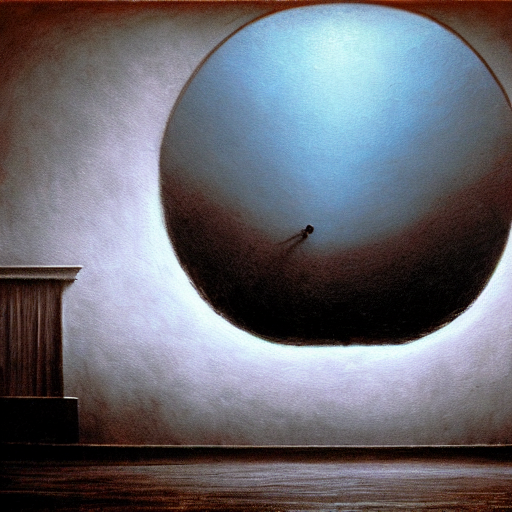

In [ ]:
#@markdown **Load Settings**
override_settings_with_file = False #@param {type:"boolean"}
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 512 #@param
    H = 512 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

    #@markdown **Sampling Settings**
    seed = 42 #@param
    sampler = 'klms' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim"]
    steps = 200 #@param
    scale = 10 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Prompt Settings**
    prompt_weighting = False #@param {type:"boolean"}
    normalize_prompt_weights = True #@param {type:"boolean"}
    log_weighted_subprompts = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    batch_name = "StableFun" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random"]
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.35 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://thumbs.dreamstime.com/b/focused-young-man-glasses-sit-library-desk-make-notes-education-concept-serious-bearded-student-teacher-hipster-study-open-book-173901884.jpg" #@param {type:"string"}
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    n_samples = 1 # doesnt do anything
    precision = 'autocast' 
    C = 4
    f = 8

    prompt = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_c = None

    return locals()



def next_seed(args):
    if args.seed_behavior == 'iter':
        args.seed += 1
    elif args.seed_behavior == 'fixed':
        pass # always keep seed the same
    else:
        args.seed = random.randint(0, 2**32 - 1)
    return args.seed

def render_image_batch(args):
    args.prompts = {k: f"{v:05d}" for v, k in enumerate(prompts)}
    
    # create output folder for the batch
    #os.makedirs(args.outdir, exist_ok=False)
    if args.save_settings or args.save_samples:
        print(f"Saving to {os.path.join(args.outdir, args.timestring)}_*")

    # save settings for the batch
    if args.save_settings:
        filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
        with open(filename, "w+", encoding="utf-8") as f:
            json.dump(dict(args.__dict__), f, ensure_ascii=False, indent=4)

    index = 0
    
    # function for init image batching
    init_array = []
    if args.use_init:
        if args.init_image == "":
            raise FileNotFoundError("No path was given for init_image")
        if args.init_image.startswith('http://') or args.init_image.startswith('https://'):
            init_array.append(args.init_image)
        elif not os.path.isfile(args.init_image):
            if args.init_image[-1] != "/": # avoids path error by adding / to end if not there
                args.init_image += "/" 
            for image in sorted(os.listdir(args.init_image)): # iterates dir and appends images to init_array
                if image.split(".")[-1] in ("png", "jpg", "jpeg"):
                    init_array.append(args.init_image + image)
        else:
            init_array.append(args.init_image)
    else:
        init_array = [""]

    # when doing large batches don't flood browser with images
    clear_between_batches = args.n_batch >= 32

    for iprompt, prompt in enumerate(prompts):  
        args.prompt = prompt
        print(f"Prompt {iprompt+1} of {len(prompts)}")
        print(f"{args.prompt}")

        all_images = []

        for batch_index in range(args.n_batch):
            if clear_between_batches and batch_index % 32 == 0: 
                display.clear_output(wait=True)            
            print(f"Batch {batch_index+1} of {args.n_batch}")
            
            for image in init_array: # iterates the init images
                args.init_image = image
                results = generate(args)
                for image in results:
                    if args.make_grid:
                        all_images.append(T.functional.pil_to_tensor(image))
                    if args.save_samples:
                        if args.filename_format == "{timestring}_{index}_{prompt}.png":
                            filename = f"{args.timestring}_{index:05}_{sanitize(prompt)[:160]}.png"
                        else:
                            filename = f"{args.timestring}_{index:05}_{args.seed}.png"
                        image.save(os.path.join(args.outdir, filename))
                    if args.display_samples:
                        display.display(image)
                    index += 1
                args.seed = next_seed(args)

        #print(len(all_images))
        if args.make_grid:
            grid = make_grid(all_images, nrow=int(len(all_images)/args.grid_rows))
            grid = rearrange(grid, 'c h w -> h w c').cpu().numpy()
            filename = f"{args.timestring}_{iprompt:05d}_grid_{args.seed}.png"
            grid_image = Image.fromarray(grid.astype(np.uint8))
            grid_image.save(os.path.join(args.outdir, filename))
            display.clear_output(wait=True)            
            display.display(grid_image)


def render_animation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # expand key frame strings to values
    keys = DeformAnimKeys(anim_args)

    # resume animation
    start_frame = 0
    #print(os.listdir(args.outdir), args.outdir)
    if anim_args.resume_from_timestring:
        for tmp in os.listdir(args.outdir):
            #print(tmp, tmp.split("_")[0], tmp.split("_")[0] == anim_args.resume_timestring, anim_args.resume_timestring)
            if tmp.split("_")[0] == anim_args.resume_timestring:
                start_frame += 1
        start_frame = start_frame - 1

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)
        
    # resume from timestring
    if anim_args.resume_from_timestring:
        args.timestring = anim_args.resume_timestring

    # expand prompts out to per-frame
    prompt_series = pd.Series([np.nan for a in range(anim_args.max_frames)])
    for i, prompt in animation_prompts.items():
        prompt_series[i] = prompt
    prompt_series = prompt_series.ffill().bfill()

    # check for video inits
    using_vid_init = anim_args.animation_mode == 'Video Input'

    # load depth model for 3D
    predict_depths = (anim_args.animation_mode == '3D' and anim_args.use_depth_warping) or anim_args.save_depth_maps
    if predict_depths:
        depth_model = DepthModel(device)
        depth_model.load_midas(models_path)
        if anim_args.midas_weight < 1.0:
            depth_model.load_adabins()
    else:
        depth_model = None
        anim_args.save_depth_maps = False

    # state for interpolating between diffusion steps
    turbo_steps = 1 if using_vid_init else int(anim_args.diffusion_cadence)
    turbo_prev_image, turbo_prev_frame_idx = None, 0
    turbo_next_image, turbo_next_frame_idx = None, 0

    # resume animation
    prev_sample = None
    color_match_sample = None
    if anim_args.resume_from_timestring:
        last_frame = abs(start_frame-1) #changed: added abs()
        if turbo_steps > 1:
            last_frame -= last_frame%turbo_steps
        path = os.path.join(args.outdir,f"{args.timestring}_{last_frame:05}.png")
        img = cv2.imread(path)
        #print(img, path, f"{args.timestring}_{last_frame:05}.png", last_frame, start_frame)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        prev_sample = sample_from_cv2(img)
        if anim_args.color_coherence != 'None':
            color_match_sample = img
        if turbo_steps > 1:
            turbo_next_image, turbo_next_frame_idx = sample_to_cv2(prev_sample, type=np.float32), last_frame
            turbo_prev_image, turbo_prev_frame_idx = turbo_next_image, turbo_next_frame_idx
            start_frame = last_frame+turbo_steps

    args.n_samples = 1
    frame_idx = start_frame
    while frame_idx < anim_args.max_frames:
        print(f"Rendering animation frame {frame_idx} of {anim_args.max_frames}")
        noise = keys.noise_schedule_series[frame_idx]
        strength = keys.strength_schedule_series[frame_idx]
        contrast = keys.contrast_schedule_series[frame_idx]
        depth = None
        
        # emit in-between frames
        if turbo_steps > 1:
            tween_frame_start_idx = max(0, frame_idx-turbo_steps)
            for tween_frame_idx in range(tween_frame_start_idx, frame_idx):
                tween = float(tween_frame_idx - tween_frame_start_idx + 1) / float(frame_idx - tween_frame_start_idx)
                print(f"  creating in between frame {tween_frame_idx} tween:{tween:0.2f}")

                advance_prev = turbo_prev_image is not None and tween_frame_idx > turbo_prev_frame_idx
                advance_next = tween_frame_idx > turbo_next_frame_idx

                if depth_model is not None:
                    assert(turbo_next_image is not None)
                    depth = depth_model.predict(turbo_next_image, anim_args)

                if anim_args.animation_mode == '2D':
                    if advance_prev:
                        turbo_prev_image = anim_frame_warp_2d(turbo_prev_image, args, anim_args, keys, tween_frame_idx)
                    if advance_next:
                        turbo_next_image = anim_frame_warp_2d(turbo_next_image, args, anim_args, keys, tween_frame_idx)
                else: # '3D'
                    if advance_prev:
                        turbo_prev_image = anim_frame_warp_3d(turbo_prev_image, depth, anim_args, keys, tween_frame_idx)
                    if advance_next:
                        turbo_next_image = anim_frame_warp_3d(turbo_next_image, depth, anim_args, keys, tween_frame_idx)
                turbo_prev_frame_idx = turbo_next_frame_idx = tween_frame_idx

                if turbo_prev_image is not None and tween < 1.0:
                    img = turbo_prev_image*(1.0-tween) + turbo_next_image*tween
                else:
                    img = turbo_next_image

                filename = f"{args.timestring}_{tween_frame_idx:05}.png"
                cv2.imwrite(os.path.join(args.outdir, filename), cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR))
                if anim_args.save_depth_maps:
                    depth_model.save(os.path.join(args.outdir, f"{args.timestring}_depth_{tween_frame_idx:05}.png"), depth)
            if turbo_next_image is not None:
                prev_sample = sample_from_cv2(turbo_next_image)

        # apply transforms to previous frame
        if prev_sample is not None:
            if anim_args.animation_mode == '2D':
                prev_img = anim_frame_warp_2d(sample_to_cv2(prev_sample), args, anim_args, keys, frame_idx)
            else: # '3D'
                prev_img_cv2 = sample_to_cv2(prev_sample)
                depth = depth_model.predict(prev_img_cv2, anim_args) if depth_model else None
                prev_img = anim_frame_warp_3d(prev_img_cv2, depth, anim_args, keys, frame_idx)

            # apply color matching
            if anim_args.color_coherence != 'None':
                if color_match_sample is None:
                    color_match_sample = prev_img.copy()
                else:
                    prev_img = maintain_colors(prev_img, color_match_sample, anim_args.color_coherence)

            # apply scaling
            contrast_sample = prev_img * contrast
            # apply frame noising
            noised_sample = add_noise(sample_from_cv2(contrast_sample), noise)

            # use transformed previous frame as init for current
            args.use_init = True
            if half_precision:
                args.init_sample = noised_sample.half().to(device)
            else:
                args.init_sample = noised_sample.to(device)
            args.strength = max(0.0, min(1.0, strength))

        # grab prompt for current frame
        args.prompt = prompt_series[frame_idx]
        print(f"{args.prompt} {args.seed}")
        if not using_vid_init:
            print(f"Angle: {keys.angle_series[frame_idx]} Zoom: {keys.zoom_series[frame_idx]}")
            print(f"Tx: {keys.translation_x_series[frame_idx]} Ty: {keys.translation_y_series[frame_idx]} Tz: {keys.translation_z_series[frame_idx]}")
            print(f"Rx: {keys.rotation_3d_x_series[frame_idx]} Ry: {keys.rotation_3d_y_series[frame_idx]} Rz: {keys.rotation_3d_z_series[frame_idx]}")

        # grab init image for current frame
        if using_vid_init:
            init_frame = os.path.join(args.outdir, 'inputframes', f"{frame_idx+1:05}.jpg")            
            print(f"Using video init frame {init_frame}")
            args.init_image = init_frame
            if anim_args.use_mask_video:
                mask_frame = os.path.join(args.outdir, 'maskframes', f"{frame_idx+1:05}.jpg")
                args.mask_file = mask_frame

        # sample the diffusion model
        sample, image = generate(args, frame_idx, return_latent=False, return_sample=True)
        if not using_vid_init:
            prev_sample = sample

        if turbo_steps > 1:
            turbo_prev_image, turbo_prev_frame_idx = turbo_next_image, turbo_next_frame_idx
            turbo_next_image, turbo_next_frame_idx = sample_to_cv2(sample, type=np.float32), frame_idx
            frame_idx += turbo_steps
        else:    
            filename = f"{args.timestring}_{frame_idx:05}.png"
            image.save(os.path.join(args.outdir, filename))
            if anim_args.save_depth_maps:
                if depth is None:
                    depth = depth_model.predict(sample_to_cv2(sample), anim_args)
                depth_model.save(os.path.join(args.outdir, f"{args.timestring}_depth_{frame_idx:05}.png"), depth)
            frame_idx += 1

        display.clear_output(wait=True)
        display.display(image)

        args.seed = next_seed(args)

def vid2frames(video_path, frames_path, n=1, overwrite=True):      
    if not os.path.exists(frames_path) or overwrite: 
      try:
          for f in pathlib.Path(video_in_frame_path).glob('*.jpg'):
              f.unlink()
      except:
          pass
      assert os.path.exists(video_path), f"Video input {video_path} does not exist"
          
      vidcap = cv2.VideoCapture(video_path)
      success,image = vidcap.read()
      count = 0
      t=1
      success = True
      while success:
        if count % n == 0:
            cv2.imwrite(frames_path + os.path.sep + f"{t:05}.jpg" , image)     # save frame as JPEG file
            t += 1
        success,image = vidcap.read()
        count += 1
      print("Converted %d frames" % count)
    else: print("Frames already unpacked")

def render_input_video(args, anim_args):
    # create a folder for the video input frames to live in
    video_in_frame_path = os.path.join(args.outdir, 'inputframes') 
    os.makedirs(video_in_frame_path, exist_ok=True)
    
    # save the video frames from input video
    print(f"Exporting Video Frames (1 every {anim_args.extract_nth_frame}) frames to {video_in_frame_path}...")
    vid2frames(anim_args.video_init_path, video_in_frame_path, anim_args.extract_nth_frame, anim_args.overwrite_extracted_frames)

    # determine max frames from length of input frames
    anim_args.max_frames = len([f for f in pathlib.Path(video_in_frame_path).glob('*.jpg')])
    args.use_init = True
    print(f"Loading {anim_args.max_frames} input frames from {video_in_frame_path} and saving video frames to {args.outdir}")

    if anim_args.use_mask_video:
        # create a folder for the mask video input frames to live in
        mask_in_frame_path = os.path.join(args.outdir, 'maskframes') 
        os.makedirs(mask_in_frame_path, exist_ok=True)

        # save the video frames from mask video
        print(f"Exporting Video Frames (1 every {anim_args.extract_nth_frame}) frames to {mask_in_frame_path}...")
        vid2frames(anim_args.video_mask_path, mask_in_frame_path, anim_args.extract_nth_frame, anim_args.overwrite_extracted_frames)
        args.use_mask = True
        args.overlay_mask = True

    render_animation(args, anim_args)

def render_interpolation(args, anim_args):
    # animations use key framed prompts
    args.prompts = animation_prompts

    # create output folder for the batch
    os.makedirs(args.outdir, exist_ok=True)
    print(f"Saving animation frames to {args.outdir}")

    # save settings for the batch
    settings_filename = os.path.join(args.outdir, f"{args.timestring}_settings.txt")
    with open(settings_filename, "w+", encoding="utf-8") as f:
        s = {**dict(args.__dict__), **dict(anim_args.__dict__)}
        json.dump(s, f, ensure_ascii=False, indent=4)
    
    # Interpolation Settings
    args.n_samples = 1
    args.seed_behavior = 'fixed' # force fix seed at the moment bc only 1 seed is available
    prompts_c_s = [] # cache all the text embeddings

    print(f"Preparing for interpolation of the following...")

    for i, prompt in animation_prompts.items():
      args.prompt = prompt

      # sample the diffusion model
      results = generate(args, return_c=True)
      c, image = results[0], results[1]
      prompts_c_s.append(c) 
      
      # display.clear_output(wait=True)
      display.display(image)
      
      args.seed = next_seed(args)

    display.clear_output(wait=True)
    print(f"Interpolation start...")

    frame_idx = 0

    if anim_args.interpolate_key_frames:
      for i in range(len(prompts_c_s)-1):
        dist_frames = list(animation_prompts.items())[i+1][0] - list(animation_prompts.items())[i][0]
        if dist_frames <= 0:
          print("key frames duplicated or reversed. interpolation skipped.")
          return
        else:
          for j in range(dist_frames):
            # interpolate the text embedding
            prompt1_c = prompts_c_s[i]
            prompt2_c = prompts_c_s[i+1]  
            args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/dist_frames))

            # sample the diffusion model
            results = generate(args)
            image = results[0]

            filename = f"{args.timestring}_{frame_idx:05}.png"
            image.save(os.path.join(args.outdir, filename))
            frame_idx += 1

            display.clear_output(wait=True)
            display.display(image)

            args.seed = next_seed(args)

    else:
      for i in range(len(prompts_c_s)-1):
        for j in range(anim_args.interpolate_x_frames+1):
          # interpolate the text embedding
          prompt1_c = prompts_c_s[i]
          prompt2_c = prompts_c_s[i+1]  
          args.init_c = prompt1_c.add(prompt2_c.sub(prompt1_c).mul(j * 1/(anim_args.interpolate_x_frames+1)))

          # sample the diffusion model
          results = generate(args)
          image = results[0]

          filename = f"{args.timestring}_{frame_idx:05}.png"
          image.save(os.path.join(args.outdir, filename))
          frame_idx += 1

          display.clear_output(wait=True)
          display.display(image)

          args.seed = next_seed(args)

    # generate the last prompt
    args.init_c = prompts_c_s[-1]
    results = generate(args)
    image = results[0]
    filename = f"{args.timestring}_{frame_idx:05}.png"
    image.save(os.path.join(args.outdir, filename))

    display.clear_output(wait=True)
    display.display(image)
    args.seed = next_seed(args)

    #clear init_c
    args.init_c = None


args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    print(f"reading custom settings from {custom_settings_file}")
    if not os.path.isfile(custom_settings_file):
        print('The custom settings file does not exist. The in-notebook settings will be used instead')
    else:
        with open(custom_settings_file, "r") as f:
            jdata = json.loads(f.read())
            animation_prompts = jdata["prompts"]
            for i, k in enumerate(args_dict):
                if k in jdata:
                    args_dict[k] = jdata[k]
                else:
                    print(f"key {k} doesn't exist in the custom settings data! using the default value of {args_dict[k]}")
            for i, k in enumerate(anim_args_dict):
                if k in jdata:
                    anim_args_dict[k] = jdata[k]
                else:
                    print(f"key {k} doesn't exist in the custom settings data! using the default value of {anim_args_dict[k]}")
            print(args_dict)
            print(anim_args_dict)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(args, anim_args)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(args, anim_args)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(args, anim_args)
else:
    render_image_batch(args)    

20221021184416_0005.png

# Create video from frames

In [ ]:
skip_video_for_run_all = True #@param {type: 'boolean'}
fps = 12 #@param {type:"number"}
#@markdown **Manual Settings**
use_manual_settings = False #@param {type:"boolean"}
image_path = "/content/drive/MyDrive/AI/StableDiffusion/2022-09/20220903000939_%05d.png" #@param {type:"string"}
mp4_path = "/content/drive/MyDrive/AI/StableDiffu'/content/drive/MyDrive/AI/StableDiffusion/2022-09/sion/2022-09/20220903000939.mp4" #@param {type:"string"}
render_steps = True  #@param {type: 'boolean'}
path_name_modifier = "x0_pred" #@param ["x0_pred","x"]


if skip_video_for_run_all == True:
    print('Skipping video creation, uncheck skip_video_for_run_all if you want to run it')
else:
    import os
    import subprocess
    from base64 import b64encode

    print(f"{image_path} -> {mp4_path}")

    if use_manual_settings:
        max_frames = "200" #@param {type:"string"}
    else:
        if render_steps: # render steps from a single image
            fname = f"{path_name_modifier}_%05d.png"
            all_step_dirs = [os.path.join(args.outdir, d) for d in os.listdir(args.outdir) if os.path.isdir(os.path.join(args.outdir,d))]
            newest_dir = max(all_step_dirs, key=os.path.getmtime)
            image_path = os.path.join(newest_dir, fname)
            print(f"Reading images from {image_path}")
            mp4_path = os.path.join(newest_dir, f"{args.timestring}_{path_name_modifier}.mp4")
            max_frames = str(args.steps)
        else: # render images for a video
            image_path = os.path.join(args.outdir, f"{args.timestring}_%05d.png")
            mp4_path = os.path.join(args.outdir, f"{args.timestring}.mp4")
            max_frames = str(anim_args.max_frames)

    # make video
    cmd = [
        'ffmpeg',
        '-y',
        '-vcodec', 'png',
        '-r', str(fps),
        '-start_number', str(0),
        '-i', image_path,
        '-frames:v', max_frames,
        '-c:v', 'libx264',
        '-vf',
        f'fps={fps}',
        '-pix_fmt', 'yuv420p',
        '-crf', '17',
        '-preset', 'veryfast',
        '-pattern_type', 'sequence',
        mp4_path
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)

    mp4 = open(mp4_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display( display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>') )

# **Extra Tools**

DALL-E2 Promptbook: http://dallery.gallery/wp-content/uploads/2022/07/The-DALL%C2%B7E-2-prompt-book-v1.02.pdf

# Example prompts:
posted at https://www.youtube.com/watch?v=_NfEC6wWhqI

This is how prompts can be build with dynamic prompting for mostly random creations. This also can be an example for your chosing:
https://colab.research.google.com/drive/1P5MEMtLM3RGCqGfSQWs1cMntrMgSnKDe?usp=sharing

"prompts":{
<br> <br>
"{A beautiful | A revolting | An award winning | An amazing | A remarkable | A  | An epic | a stunnning | A magnificent} <br><br>
    {pixar image | matte painting | 3D render | oil painting | photograph | sculpture |digital illustration | watercolor | colored pencil sketch | photo shoot | acrylic painting} 
<br><br>
of 
<br><br>
{silly | sexy | exotic | beautiful | elegant | creepy | hilarious | evil | Angelic | sublime | ridiculous}
<br><br>
 {rococo cauliflower headdress | cauliflower cornucopia | macro romanesco | cauliflower Cthulhu | cauliflower nuclear explosion | Cauliflower mushroom cloud | Hubble cauliflower nebula | nebula | cauliflower infestation | steampunk cauliflower | magic rubber cauliflower | psychedelic cauliflower | cauliflower couture | cabin} 
<br><br>
In
<br><br>
 {corporate office setting | abandoned warehouse | schoolhouse | victorian train station | victorian room | Lake | Field of wild flowers | submarine | swamp | assembly line | surface of the moon | museum | outer space |storefront display | galaxy | museum | black hole | subsuming vortex} 
<br><br>
in
<br><br>
 {morning | sunset| noon | night | evening | dawn | twilight} <br>
 (for lighting, film types look in http://dallery.gallery/wp-content/uploads/2022/07/The-DALL%C2%B7E-2-prompt-book-v1.02.pdf)
 <br><br>
 by
 <br><br>
//choose 1 to 3 for each prompt <br>
[James Jean | Lucian Freud | tomm moore  | wes anderson  | ernst haeckl | tim burton  | jean pierre jeunet | jean giraud moebius | takashi murakami | ross draws |  artgerm |  alvin ailey |  Zdzisław Beksiński |  Arthur Rackham |  Dariusz Zawadzki |  thomas kincade  |  greg rutkowski  |  rembrandt |  HR Giger |  jama jurabaev | wenwei zhu | frank franzzeta | mcbess | sakimi chan | brosmind | steve simpson | jim henson | Nicoletta Ceccoli | Margaret Keane | Mark Ryden | Severin Krøyer | Marie Krøyer | Karl Madsen| Laurits Tuxen| Carl Locher| Viggo Johansen| Thorvald Niss | Holger Drachmann | Raluca bararu | walton ford | josh Keyes | Marco Mazzoni | Susan Helen Strok | R Crumb | Beatrix potter | shaw brothers | victor moscoso | Thomas Kinkade | Vincent Van Gogh | Leonid Afremov | Claude Monet | Edward Hopper | Norman Rockwell | William-Adolphe Bouguereau | Albert Bierstadt | John Singer Sargent | Pierre-Auguste Renoir | Frida Kahlo | John William Waterhouse | Winslow Homer | Walt Disney | Thomas Moran | Phil Koch | Paul Cézanne | Camille Pissarro | Erin Hanson | Thomas Cole | Raphael | Steve Henderson | Pablo Picasso | Caspar David Friedrich | Ansel Adams | Diego Rivera | Steve McCurry | Bob Ross | John Atkinson Grimshaw | Rob Gonsalves | Paul Gauguin | James Tissot | Edouard Manet | Alphonse Mucha | Alfred Sisley | Fabian Perez | Gustave Courbet | Zaha Hadid | Jean-Léon Gérôme | Carl Larsson | Mary Cassatt | Sandro Botticelli | Daniel Ridgway Knight | Joaquín Sorolla | Andy Warhol | Kehinde Wiley | Alfred Eisenstaedt | Gustav Klimt | Dante Gabriel Rossetti | Tom Thomson | Edgar Degas | Utagawa Hiroshige | Camille Corot | Edward Steichen | David Hockney | Ivan Aivazovsky | Josephine Wall | Peter Paul Rubens | Henri Rousseau | Edward Burne-Jones | Pixar | Alexander McQueen | Anders Zorn | Jean Auguste Dominique Ingres | Franz Xaver Winterhalter | Katsushika Hokusai | John Constable | Canaletto | Shepard Fairey | Gordon Parks | George Inness | Anthony van Dyck | Vivian Maier | Catrin Welz-Stein | Lawren Harris | Salvador Dali | David Bowie | Agnes Cecile | Titian | Martin Johnson Heade | Scott Naismith | William Morris | Berthe Morisot | Vladimir Kush | William Holman Hunt | Edvard Munch | Joseph Mallord William Turner | Gustave Doré | Thomas Eakins | Ilya Repin | Amedeo Modigliani | Johannes Vermeer | Eyvind EarleIvan Shishkin | Rembrandt Van Rijn | Gil Elvgren | Nicholas Roerich | Henri Matisse | Thomas Gainsborough | Artgerm | Studio Ghibli | Grant Wood | Jeremy Mann | Mark Keathley | Maxfield Parrish | Andrew Wyeth | RHADS | David Lynch | Frederic Remington | Jan Van Eyck | Mikko Lagerstedt | Banksy | Michael Cheval | Anna Razumovskaya | Jean-François Millet | Thomas W Schaller | Charlie Bowater | El Greco | Paolo Roversi | Carne Griffiths | Man Ray | August Sander | Andrew Macara | Evelyn De Morgan | William Blake | Sally Mann | Oleg Oprisco | Yuumei | Helmut Newton | Henry Ossawa Tanner | Asher Brown Durand | teamLab | August Macke | Armand Guillaumin | Terry Redlin | Antoine Blanchard | Anna Ancher | Ohara Koson | Walter Langley | Yayoi Kusama | Stan Lee | Chuck Close | Albert Edelfelt | Mark Seliger | Eugene Delacroix | John Lavery | Theo van Rysselberghe | Marc Chagall | Rolf Armstrong | Brent Heighton | A.J.Casson | Egon Schiele | Maximilien Luce | Georges Seurat | George Frederic Watts | Arthur Hughes | Anton Mauve | Lucian Freud | Jessie Willcox Smith | Leonardo Da Vinci | Edward John Poynter | Brooke Shaden | J.M.W. Turner | Wassily Kandinsky | Wes Anderson | Jean-Honoré Fragonard | Amanda Clark | Tom Roberts | Antonello da Messina | Makoto Shinkai | Hayao Miyazaki | Slim Aarons | Alfred Stevens | Albert Lynch | Andre Kohn | Daniel Garber | Jacek Yerka | Beatrix Potter | Rene Magritte | Georgia O'Keeffe | Isaac Levitan | Frank Lloyd Wright | Gustave Moreau | Ford Madox Brown | Ai Weiwei | Tim Burton | Alfred Cheney Johnston | Duy Huynh | Michael Parkes | Tintoretto | Archibald Thorburn | Audrey Kawasaki | George Lucas | Arthur Streeton | Albrecht Durer | Andrea Kowch | Dorina Costras | Alex Ross | Hasui Kawase | Lucas Cranach the Elder | Briton Rivière | Antonio Mora | Mandy Disher | Henri-Edmond Cross | Auguste Toulmouche | Hubert Robert | Syd Mead | Carl Spitzweg | Alyssa Monks | Edward Lear | Ralph McQuarrie | Sailor Moon | Simon Stalenhag | Edward Robert Hughes | Jules Bastien-Lepage | Richard S. Johnson | Rockwell Kent | Sparth | Arnold Böcklin | Lovis Corinth | Arnold Bocklin | Robert Hagan | Gregory Crewdson | Thomas Benjamin Kennington | Abbott Handerson Thayer | Gilbert Stuart | Louis Comfort Tiffany | Raphael Lacoste | Jean Marc Nattier | Janek Sedlar | Sherree Valentine Daines | Alexander Jansson | James Turrell | Alex Grey | Henri De Toulouse Lautrec | Anton Pieck | Ramon Casas | Andrew Atroshenko | Andy Kehoe | Andreas Achenbach | H.P. Lovecraft | Eric Zener | Kunisada | Jimmy Lawlor | Quentin Tarantino | Marianne North | Vivienne Westwood | Tom Bagshaw | Jeremy Lipking | John Martin | Cindy Sherman | Scott Listfield | Alexandre Cabanel | Arthur Rackham | Arthur Hacker | Henri Fantin Latour | Mark Ryden | Peter Holme IIIT | ed Nasmith | Bill Gekas | Paul Strand | Anne Stokes | David Teniers the Younger | Alan Lee | Ed Freeman | Andrey Remnev | Alasdair McLellan | Botero | Vittorio Matteo Corcos | Ed Mell | Worthington Whittredge | Jakub Różalski | Alex Gross | Edward Weston | Ilya Kuvshinov | Francisco De Goya | Balthus | J.C. Leyendecker | Nathan Wirth]

<br><br>
//choose up to 4 <br>
[warm tones | highly detailed | photorealistic | realistic | hypermaximalist | hyperrealism, intricate | artstation | HD | 8k | 4k | octane render | subsurface scattering raytracing | depth of field | bokeh | redshift render | abstract illusionism | Atmospheric | Dramatic lighting | Anthropomorphic | 8k | Very detailed | Cinematic lighting | Unreal engine | Octane render | Photorealistic | Hyperrealistic | Sharp focus | Rim lighting | Soft lighting | Volumetric | Surreal | Realistic CGI | Fantastic backlight | HDR | Studio light | Internal glow | Iridescent | Cyberpunk | Steampunk | Intricate  | filigree | Bionic futurism | Ray tracing | Symmetrical | Atompunk | Multiverse | Concept art | Time loop | Maximum texture | Futurism | Dynamic | retrowave | afrofuturism | intricate and highly detailed |  intricate and highly detailed |  intricate and highly detailed |  intricate and highly detailed |  intricate and highly detailed | photorealistic |  photorealistic |  photorealistic |  photorealistic]

<br><br>
//may include these camera settings/angles yourself: <br>
[Fast shutter speed |<br>
 Tilt shift photography |<br>
 Macro lens |<br>
 Wide angle lens |<br>
 Deep depth of field |<br>
 ...
 <br>
 Extreme close-up |<br>
 close-up |<br>
 Medium shot |<br>
 long shot |<br>
 Extreme long shot |<br>
 ...
 <br>
Overhead view / establishing shot / high angle | <br>
Low angle / worms-eye-view / shot from below | <br>
tilted frame, 35° / Dutch angle | <br>
Over-the-shoulder shot ]
"

# **Artists**
-It is adviced to take 1 to 3 artists


## Epochs


*   Surrealism: 
    <br> Magritte, Salvador Dali, Andre Breton, Max Ernst, Yves Tanguy, Vladimir Kush, James Mccarthy, Jaroslaw Jasnikowski
<br><br>
*   Realism:<br>
    Gustave Courbet
<br><br>
*   Futurism<br>
    Umberto Boccioni, Gino Severini, Carlo Carrà, Luigi Russolo
<br><br>
*   Renaissance:<br>
    Giorgio Vasari, El Greco
<br><br>
*   Baroque<br>
    Velázquez, Caravaggio, Vermeer, Peter Paul Rubens
<br><br>
*   Rococo:<br>
    Antoine Watteau
<br><br>
*   Neo-classicism<br>
    Anne Vallayer-Coster, Angelica Kauffmann, Jacques-Louis David, Johann Zoffany
<br><br>
*   Realism:<br>
    John William Waterhouse

*   Symbolism<br>
    Edward Burne-Jones
<br><br>
*   Impressionism:<br>
    Anna Ancher, Mary Cassatt, William Merritt Chase, Vincent van Gogh,     Gustave     Caillebotte, Georges Lemmen, Max Liebermann, Henri Rousseau
<br><br>
*   Cubism:<br>
    Pablo Picasso
<br><br>
*   Neo-expressionism:<br>
    Max Beckmann, Ernst Ludwig Kirchner, James Ensor, Edvard Munch
<br><br>
*   Ukiyo-e:<br>
    Ohara Koson, Utagawa Hiroshige, Katsushika Hokusai
<br><br>
*   Metaphysical painting:
    <br> Giorgio de Chirico, Carlo Carrà, Filippo De Pisis
<br><br>
*   Magical Realism (abstract, repeating objects, nice realistic oil paint)
    <br>Rob Gonsalves (special repeating of objects), Alexander Kanoldt

Inspired? Try Google's Arts & Culture Hub [https://artsandculture.google.com/explore] to find 13,000 more artists you can work with.





---

# Digital artworks, Modern art and specific topics

### Human, faces, bodies

*   Oil body painting, 3d statues: 
    <br> Michael Parkes
*   Multiple humans together in motion
    <br> Alvin Ailey
*   Faces:
    <br> Lucian Freud (Expressionistic, harsh, ugly), Rembrandt (Baroque Portraits, oil paint), Marco Mazzoni (Disturbing, Flowers/Birds cover the face) 
*   Full Portrait (only woman, soft look, real-looking)
    <br> William-Adolphe Bouguereau, John Singer Sargent,  Raphael (Renaissance portraits)
*   Heroic woman
    <br> Artgerm (comics of woman), Ross Draws (digital artworks of woman),    Steve Henderson (woman in landscape with fancy fabric flying in wind)

---
###Landscapes

*   usual-looking
    <br>  Thorvald Niss, Anton Mauve
*   Watercolor landscape:
    <br> Slawek Fedorczuk, Claude Monet, Pierre-Auguste Renoir 
*   painted landscapes (less detailed as drawn with brush)
    <br>  William Wendt, Thomas Moran
*   Real-looking pleasant landscape:
    <br> Gustave Caillebotte, Bob Ross, Ivan Shishkin (pure natural forest), Albert Bierstadt (very gorgeous),  Thomas Cole, Caspar David Friedrich (very wide and sparse landscape)
*   colorful real-looking landscapess:
    <br> Ben Saber (heavy blue-red contrast), Thomas Kinkade (mythical glowing + houses),  Erin Hanson  (red-lit forests in dawn)
*   abstract landscape:
    <br> Eyvind Earle (shapes, patterns)  Phil Koch (nice-looking, expressionism), Henri Rousseau (dense forests, leaves shapes, Impressionism)
*   Sea:
    <br> Winslow Homer, Ivan Aivazovsky

---

###Comics, illustrations, animations

*   Heroic woman
    <br> Artgerm (comics of woman)
*   Surrealistic Comic drawings
    <br> Jean Giraud Moebius
*   Black and white trick film characters
    <br> Tim Burton (more detailed, lighing), Mcbess, Vivian Maier (more real human photos)
*   beatiful trick film animation
    <br> Tomm Moore
*   Walt Disney, Pixar
*   Childrens book illustrations (landscape, animals)
    <br> Matthew Forsythe
*   American movie inspired Popart
    <br> Wes Anderson
*   Japanese anime (with quality)
    Hiyao Miyazaki
*   Shepard Fairey
---


### Fantasy, mythological

*   mythical fantasy creatures:
    <br> Anne Stokes (Stunning background), greg rutkowski (Sinister background),  Frank Franzzeta (Sinister, much content)
*   mythical paintings of people: 
    <br> Charlie Bowater 

---

### Animals

*   Drawn Animals:
    <br> Ernst Haeckl (very colorful detailed, patterns), Ohara Koson (japanese), Beatrix Potter (watercolor fairytale figures), Wenwei Zhu (watercolor)


---

### Other


*   Painted Rooms:
    <br> August von Brandis (~1850, old paint), Edward Hopper (far open space, vibrant)
*   Ancient cities: <br>
    Canaletto (Italien ~1750)
*   Robotic artworks:
    <br> Simon Stålenhag
*   dystopian surrealism (creepy, disturbing):
    <br> Zdzisław Beksiński, Dariusz Zawadzki, Peter Gric
*   Xenomorphic alien art:
    <br> HR Giger
*   Fractal, Space patters (phone hull)
    <br> Andi GreyScale

*   Psychedelic:
    <br> Simon Haiduk, Josephine Wall
*   Mass of objects, chaotic
    <br> Norman Rockwell (+ people)

---  

### Single artist styles:
  *   Leonid Afremov
        --> thousand paper lanterns in a street (excellent for explosions, crackling fireworks)
  *   Kehinde Wiley --> Nice Flower Wallpaper, + one Person
  *   Diego Rivera --> Mexican modern art
  *   John Atkinson Grimshaw --> Dim green/yellow streets of 1850
  *   David Hockney
  *   Alexander McQueen --> fashion designs
    
### Other and recommended:
  *   tomasz alen kopera
  *   Hieronymus Bosch
  *   H.P. Lovecraft (Cthulhu, dark, soft, dark and good background)

https://www.youtube.com/watch?v=2xXadULdhcg&t=97s

ITS SO IMPORTANT. Use a high strength (0.63) through standard scenes to maintain some coherence, and then JUICE it with low strength 
(0.50 or something) for a couple of frames when you are transitioning prompts, to help the AI convert over and NOT get stuck on the old prompt. 
Also if you are rendering and you're not getting any good stuff, you can JUICE it with some low strength just to mix things up.



I may not have included it because its too much text, its also customary to do noise scheduling as well. I run 0.02 and 
then hit it with 0.07 every 15 frames (with each prompt having 150 frames) for 2 frames. It just keeps things JUICY. 
<br><br>Noise scedule: https://replit.com/@dreamingtulpa/NoiseSchedule#main.rb
<br> Warning: Never forget to define frame 0 with this. Using outputs from below causes an UnboundLocalError

<b> Noise schedule </b> <br>

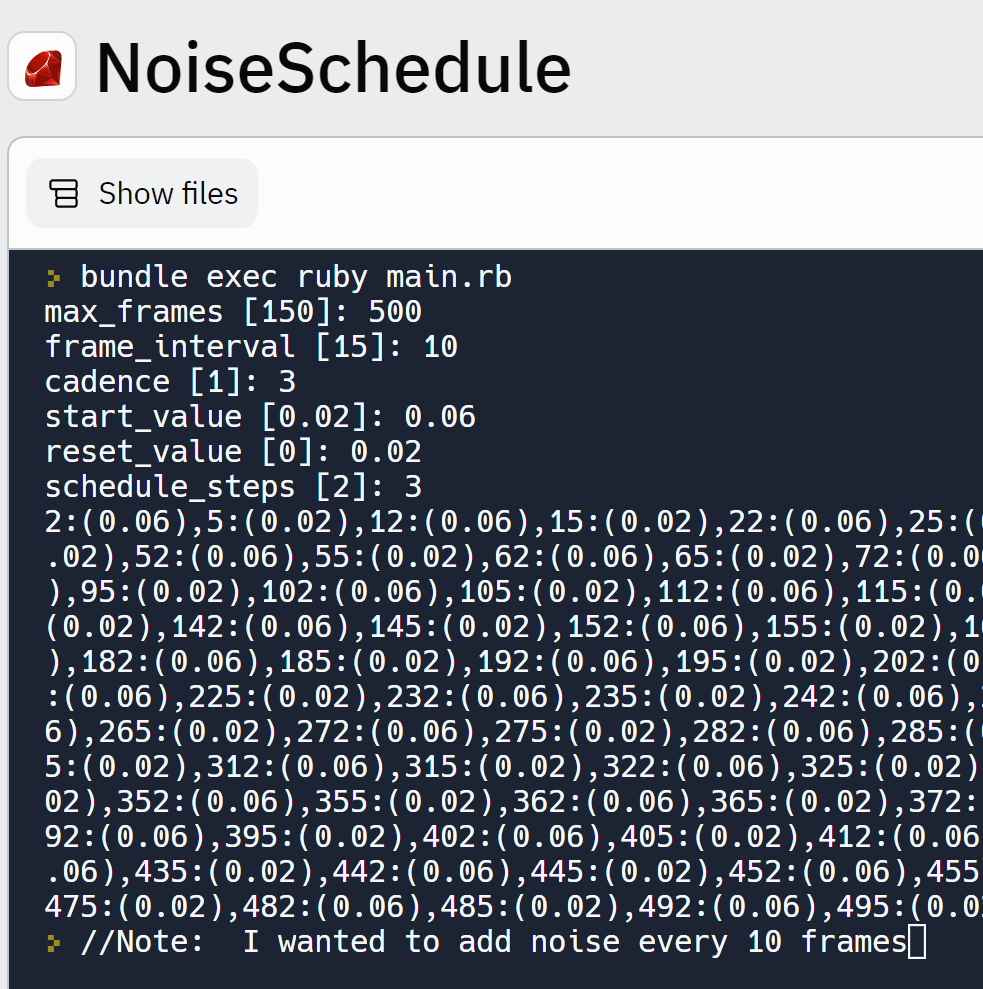

<b> Strength schedule </b> <br>

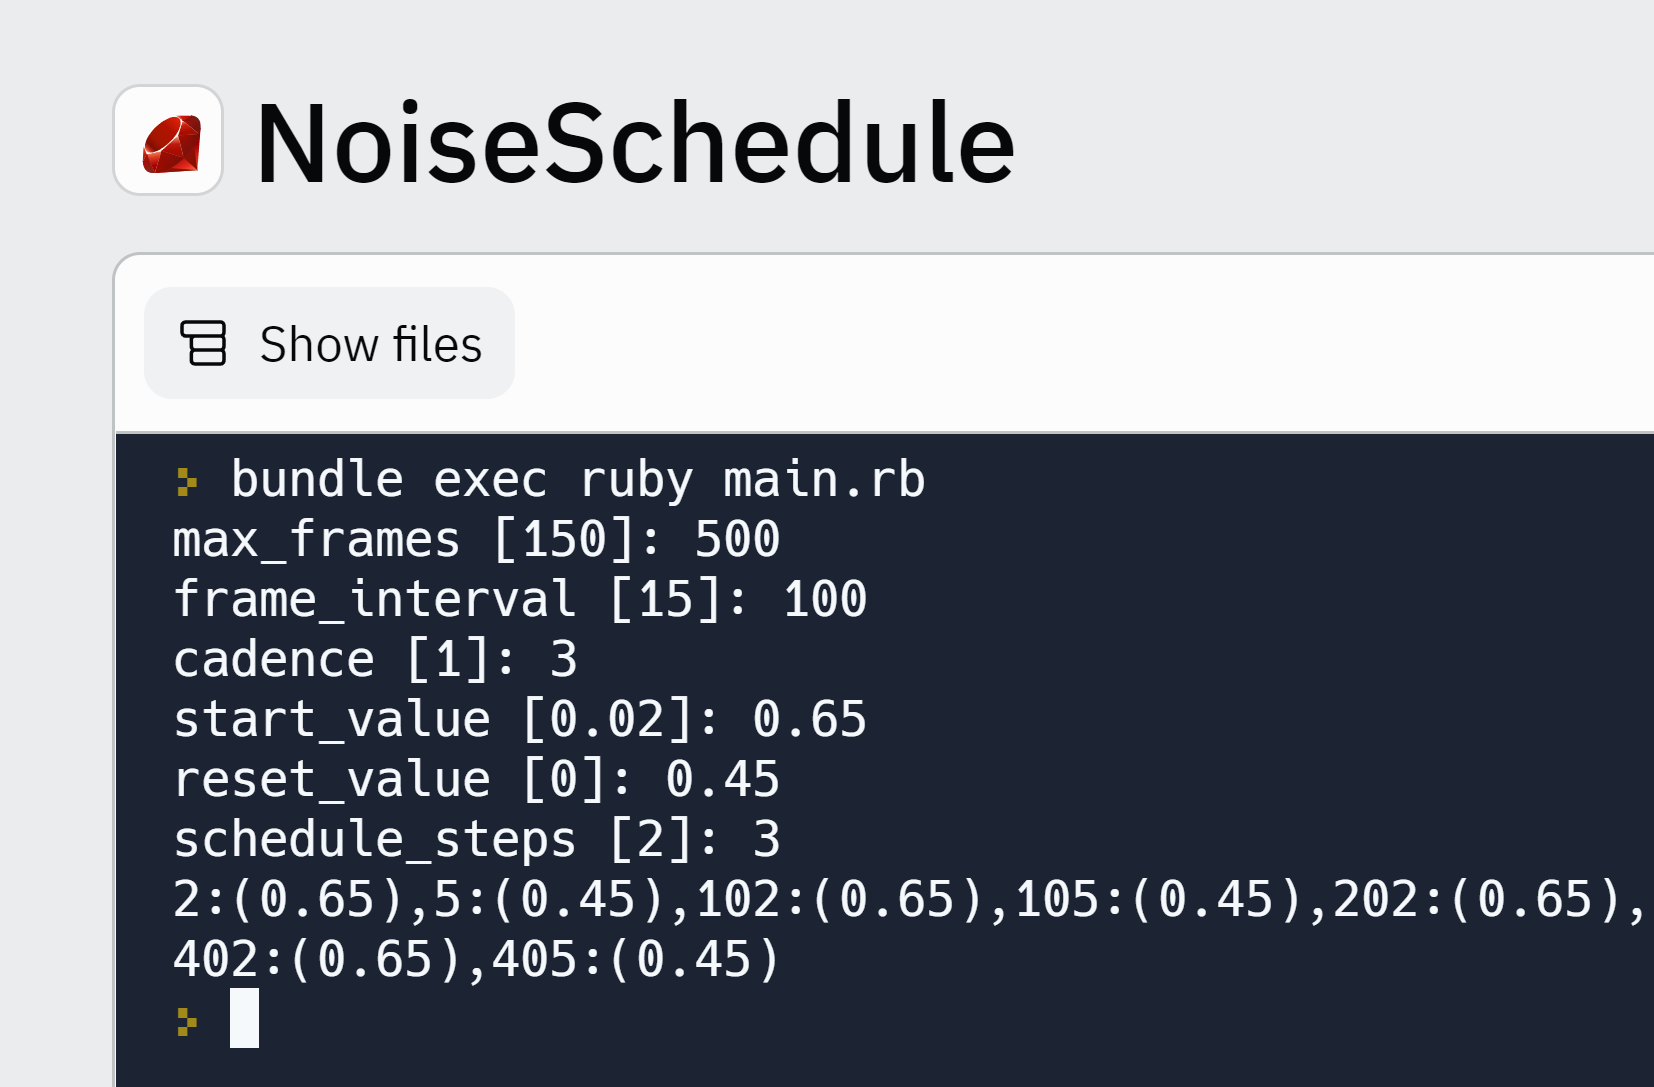

## Note:

*   Translation (negtive values go always in direction of an axis): 
  *  2D/2D X and Y translation
  *  Slow: +-3
  *  Medium +-6
  *  Fast +-9
*   Zoom
  * 2D Zoom (factor of 1; change per frame!):
      * Slow: 1 +- 0.01 
      * Medium: 1 +- 0.04 
      * Fast   1 +- 0.1
  * 3D Z: Zooming in/out (+/-)
*  Angle (Change in degrees/s; positive vals go counter-clockwise)
  *  Slow +-1
  *  Medium +-3
  *  Fast +-5
    *  X: Rotates Like looking up/down (+/-) 
    *  Y: Rotates like turning around (left/right) (-/+)
    *  Z: Rotates like barrel-rolling left/right (-/+)

---

##Prepared Camera Movements
   -  inward zoom + turn
   -  outward zoom
   -  turning around
   -  falling back
   -  harmonic slight movements
   -  diving in with tilted angle
   -  simple translations


## Camera Movement Tools:

posted in https://www.youtube.com/watch?v=rjr3dGXof_I&t

Define your 3D camera movement here:
https://colab.research.google.com/github/zippy731/wiggle/blob/main/Wiggle_Standalone_5_1.ipynb